# Inicio

## Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
         r"\usepackage{url}",            # load additional packages
         r"\usepackage{unicode-math}",   # unicode math setup
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

import seaborn as sns
from scipy import stats
import random

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

with open('res_sub_tab.txt', 'w') as res_sub_tab:
    res_sub_tab.write('Tabelas Latex para os resultados dos métodos subjetivos')
    res_sub_tab.write('\n')
    res_sub_tab.close()

#Cores
ccmLBlue = (0.170/0.255,0.200/0.255,0.230/0.255)
ccmBlue = (0.020/0.255,0.080/0.255,0.200/0.255)
ccmDBlue = (0.025/0.255,0.050/0.255,0.120/0.255)
ccmRed = (0.190/0.255,0.0,0.0)
ccmOrange = (0.255/0.255,0.100/0.255,0.0)
ccmLGray = (0.210/0.255,0.210/0.255,0.210/0.255)
ccmDGray = (0.085/0.255,0.085/0.255,0.085/0.255)

cor1 = ccmRed
cor2 = ccmDBlue
cor3 = ccmLGray
cor4 = ccmOrange
cor5 = ccmLBlue
cor6 = ccmDGray
cor7 = ccmBlue

# Create an array with the colors you want to use
paletaCores = [cor1,cor2,cor3,cor4,cor5,cor6,cor7]
# Set your custom color palette
sns.set_palette(sns.color_palette(paletaCores))
plt.rcParams.update({'font.size': 22})


## Funções

### Tabela Latex

In [2]:
def tabela_latex(df,label,caption,teste,floatBarrier = False):
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format)
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + '.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

def tabela_latex_sem_index(df,label,caption,teste,floatBarrier = False):
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format, index = False)
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + '.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

### Anova

In [3]:
def AnovaTable(df):
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    fatores = len(df.columns)
    mediaGeral = totalGeral/N

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f

    SS_lista = [SS_f, SS_e, SS_t]

    # Graus de liberdade
    gL_1 = len(df.columns) - 1
    gL_2 = N - len(df.columns)
    gL = gL_1 + gL_2
    gL_lista = [gL_1, gL_2, gL]

    # Média dos erros
    MS_f = SS_f/gL_1
    MS_e = SS_e/gL_2
    MS_lista = [MS_f, MS_e, '']

    # Fator F
    F = MS_f/MS_e
    F_lista = [F,'' ,'' ]

    # p-Value
    p_value = stats.f.sf(F, gL_1, gL_2, loc=0, scale=1)
    P_value_list = [p_value, '', '']

    Fonte = ['Entre fatores', 'Dentro dos fatores', 'Total']

    df_summary = pd.DataFrame([], columns = ['Fonte', 'Soma dos quadrados', 'Graus de liberdade', 'Média quadrada', 'F', 'p-Value (F_0 > F)'])
    df_summary['Fonte'] = Fonte
    df_summary['Soma dos quadrados'] = SS_lista
    df_summary['Graus de liberdade'] = gL_lista
    df_summary['Média quadrada'] = MS_lista
    df_summary['F'] = F_lista
    df_summary['p-Value (F_0 > F)'] = P_value_list

    print(df_summary.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_summary

def LSDPostHocAnova(df):
    alpha = 0.05
    nomeFatores = df.columns
    
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    mediaGeral = totalGeral/N

    # Graus de liberdade
    gL_2 = N - len(df.columns)

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f

    # Média dos erros
    MS_e = SS_e/gL_2


    LSD = stats.t.isf(alpha,gL_2)/2 * np.sqrt(2*MS_e/len(df.iloc[:,1]))

    df_postHoc = pd.DataFrame([], columns = ['Comparação', 'Resultado'])
    comparaçãoLista = []
    resultadoLista = []

    mediaFator = []
    for a in df.columns:
        somaFator = 0
        for n_ij in df[a]:
            somaFator = somaFator + n_ij
        mediaFator.append(somaFator/len(df[a]))
    i = 0
    while i < len(mediaFator):
        j = 0
        while j < len(mediaFator):
            if (i<j and i!=j):
                comparaçãoLista.append(nomeFatores[i] + ' versus ' + nomeFatores[j])
                if (abs(mediaFator[i] - mediaFator[j])>=LSD):
                    resultadoLista.append('**H_1 : \mu_' + nomeFatores[i] + ' != \mu_' + nomeFatores[j] + '**')
                else:
                    resultadoLista.append('H_0 : \mu_' + nomeFatores[i] + ' == \mu_' + nomeFatores[j])
            j = j + 1
        i = i + 1
    df_postHoc['Comparação'] = comparaçãoLista
    df_postHoc['Resultado'] = resultadoLista
    print('Se a diferença entre alguma média for superior a {lsd:.2f} então a hipótese alternativa pode ser valida para essa determinada comparação'.format(lsd = LSD))
    print(df_postHoc.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_postHoc

def DunnettPostHocAnova(df,dun_0,controle):
    df.drop(columns = controle.name, inplace= True)
    
    #alpha = 0.05
    nomeFatores = df.columns

    nomeControle = controle.name
    dun = dun_0 * np.sqrt(2*MS_e/len(df.iloc[:,1]))

    
    df_postHoc = pd.DataFrame([], columns = ['Comparação', 'Resultado'])
    comparaçãoLista = []
    resultadoLista = []

    mediaFator = []
    for a in df.columns:
        somaFator = 0
        for n_ij in df[a]:
            somaFator = somaFator + n_ij
        mediaFator.append(somaFator/len(df[a]))

    mediaControle = 0
    for n_i in controle:
        somaFator = somaFator + n_i
    mediaControle = somaFator/len(controle)

    for m in range(len(mediaFator)):
        comparaçãoLista.append(nomeFatores[m] + ' versus ' + nomeControle)
        if (abs(mediaFator[m] - mediaControle)>=dun):
            resultadoLista.append('**H_1 : \mu_' + nomeFatores[m] + ' != \mu_' + nomeControle + '**')
        else:
            resultadoLista.append('H_0 : \mu_' + nomeFatores[m] + ' == \mu_' + nomeControle)

    df_postHoc['Comparação'] = comparaçãoLista
    df_postHoc['Resultado'] = resultadoLista
    print('Se a diferença entre alguma média for superior a {dun:.2f} então a hipótese alternativa pode ser valida para essa determinada comparação'.format(dun = dun))
    print(df_postHoc.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

# Leitura e organização dos dados

## Leitura dos dados brutos

In [4]:
df = pd.read_excel("Todas as respostas.xlsx")
participantes = df.loc[:,['Participante:','Idade:','Sexo:','Como deficiente visual você se identifica como:']]
participantes.set_index('Participante:', drop = True, inplace = True)
df_resto_1 = df.drop(['Idade:','Sexo:','Como deficiente visual você se identifica como:','Qual o cenário'],axis = 1)
df_resto_1

,Participante:,Ordem dos cenários [Primeiro],Ordem dos cenários [Segundo],Ordem dos cenários [Terceiro],Ordem dos cenários [Quarto],Ordem dos cenários [Quinto],1.1) Demanda Mental,1.1) Demanda física,1.1) Demanda Temporal,1.1) Perfomance,...,Tempo Total 1,Tempo Total 2,Tempo Total 3,Tempo Total 4,Tempo Total 5,Tempo Total 6,Tempo Total 7,Tempo Total 8,Tempo Total 9,Tempo Total 10
0,002C,4,1,5,3,2,5,1,1,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001,4,1,3,5,2,6,7,6,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001C,3,5,4,1,2,3,2,1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,003,3,1,5,2,4,2,3,2,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,003C,1,3,4,5,2,5,1,1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Separação dos dados

### Ordem dos cenários

In [5]:
ordemCenarios = df_resto_1.iloc[:,range(0,6)]
#ordemCenarios = ordemCenarios.drop(ordemCenarios.columns[range(1,4)], axis = 1)
ordemCenarios.set_index(keys = "Participante:", inplace = True)
df_resto_2 = df_resto_1.drop(ordemCenarios.columns,axis = 1)


### Nasa

In [6]:
cenas = list(range(1,6))
nomeCenas = ['Base', 'Audio', 'Haptic Belt', 'Virtual Cane', 'Mixture']
etapas = [1,2]
dimensoesNasa = ['Demanda Mental','Demanda física', 'Demanda Temporal', 'Perfomance', 'Esforço', 'Frustação']
dimensoesNasas_todas = ['Participante:']
for c in cenas:
    for e in etapas:
        for d in dimensoesNasa:
            nome = str(c) + '.' + str(e) + ') '+ d
            dimensoesNasas_todas.append(nome)

dfNasa = df_resto_2.loc[:,dimensoesNasas_todas]
dfNasa.set_index('Participante:',inplace = True)
df_resto_3 = df_resto_2.drop(dfNasa.columns, axis = 1)
# dfNasa.head()


### Sagat

In [7]:
perguntasSagat = ['Existe algum objeto próximo de você?', 'Sinalize onde o objeto está', 'Existe alguém perto de você?', 'Sinaliza onde está pessoa esta', 
'Você percebeu alguma fonte de som característica do lugar onde você se encontra?', 'Sinalize de onde vem o som', 'Sinalize em que direção está a recepcionista', 
'Sinalize em que direção está a saída', 'Qual a distância você imagina que existe entre a mesa da recepção e qual direção ela está?',	
'Qual a distância você imagina que existe entre a saída?']

perguntasSagat_todas = ['Participante:'] 
for c in cenas:
    for e in etapas:
        for p in perguntasSagat:
            nome = str(c) + '.' + str(e) + ') '+ p
            perguntasSagat_todas.append(nome)

dfSagat = df_resto_3.loc[:,perguntasSagat_todas]
dfSagat.set_index('Participante:',inplace = True)
df_resto_4 = df_resto_3.drop(dfSagat.columns, axis = 1)
#dfSagat.head()

### Tempo

In [8]:
dfTempo = df_resto_4.iloc[:,-10:]
df_resto_5 = df_resto_4.drop(dfTempo.columns, axis = 1)

### Questionário dos métodos de guiagem

In [9]:
dfQuestionario = df_resto_5.set_index('Participante:')
#dfQuestionario.head()

## Reorganizar os dados

### Transformar dados qualitativos em quantitativos

Cego ficou definido como número 0
Vidente ficou definido como número 1

Masculino ficou definido como número 0
Feminino ficou definido como número 1

In [10]:
sexo = []
for s in participantes.iloc[:,1]:
    if s == 'Masculino':
        sexo.append(0)
    else:
        sexo.append(1)

visual = []
for v in participantes.iloc[:,2]:
    if v == 'Não sou deficiente visual':
        visual.append('Sight')
    else:
        visual.append('Blind')

participantes.insert(2,'Sexo 0/1', sexo)
participantes.insert(4,'Deficiência visual', visual)
participantes

,Idade:,Sexo:,Sexo 0/1,Como deficiente visual você se identifica como:,Deficiência visual
Participante:,,,,,
002C,26,Masculino,0,Cego,Blind
001,22,Masculino,0,Não sou deficiente visual,Sight
001C,56,Masculino,0,Cego,Blind
003,28,Masculino,0,Não sou deficiente visual,Sight
003C,42,Masculino,0,Cego,Blind


### Nasa

In [11]:
nasa = []
for p in range(len(participantes)):
    nasaPorCena = []
    for c in range(len(cenas)):
        nasaPorEtapa = []
        for e in range(len(etapas)):
            nasaEtapa = []
            for d in range(len(dimensoesNasa)):
                #print(dfNasa.iloc[d+e*6+c*12])
                nasaEtapa.append(dfNasa.iloc[p,d+e*6+c*12])
            nasaPorEtapa.append(nasaEtapa)
        nasaPorCena.append(nasaPorEtapa)
    nasa.append(nasaPorCena)
#nasa

### Sagat

In [12]:
sagat = []
for p in range(len(participantes)):
    sagatPorCena = []
    for c in range(len(cenas)):
        sagatPorEtapa = []
        for e in range(len(etapas)):
            sagatEtapa = []
            for d in range(len(perguntasSagat)):
                #print(dfSagat.iloc[d+e*10+c*20])
                sagatEtapa.append(dfSagat.iloc[p,d+e*10+c*20])
            sagatPorEtapa.append(sagatEtapa)
        sagatPorCena.append(sagatPorEtapa)
    sagat.append(sagatPorCena)
#sagat

### Questionários dos métodos de guiagem

In [13]:
perguntasQuestionario = [7,6,7,20]

questionarios = []
for p in range(len(participantes)):
    questionariosPorCena = []
    for c in range(len(cenas)-1):
        questionarioCena = []
        for d in range(perguntasQuestionario[c]):
            #print(dfQuestionario.iloc[d+sum(perguntasQuestionario[:c])])
            questionarioCena.append(dfQuestionario.iloc[p,d+sum(perguntasQuestionario[:c])])
        questionariosPorCena.append(questionarioCena)
    questionarios.append(questionariosPorCena)
questionarios

[[[1, 1, 7, 4, 1, 1, 'Não'],
  [7, 1, 1, 4, 1, 'Não, mas o vibrar do controle é um bom complemento'],
  [5, 1, 7, 1, 3, 'Indicar o que esta na superficie da mesa', 'Não fez ainda'],
  [1, 1, 7, 7, 7, 1, 7, 1, 1, 7, 1, 7, 4, 7, 4, 7, 1, 1, 'Não', 'Não']],
 [[3, 4, 7, 6, 7, 3, 'Não'],
  [2, 2, 5, 5, 3, 'Não'],
  [5, 0, 2, 4, 3, 'N]ao', 'Bengala. Achou ela mais precisa'],
  [4, 5, 6, 5, 5, 3, 3, 2, 4, 2, 3, 7, 5, 6, 0, 3, 1, 2, 'Não', 'Cinto']],
 [[2, 1, 4, 6, 7, 3, 'Sim. Em qual sentido está o objeto'],
  [5, 1, 5, 5, 3, 'Sim. Ele não informou onde estava as paredes'],
  [5,
   3,
   6,
   1,
   1,
   'Sim. Não informa o formato do objeto (quando comparado com a bengala)',
   'Bengala, mais preciso (pode escolher onde aponta)'],
  [2,
   3,
   0,
   0,
   0,
   0,
   6,
   1,
   1,
   6,
   1,
   0,
   3,
   5,
   3,
   5,
   1,
   2,
   'Sim. INformação sobre o formato do objeto',
   'Audio foi desnecessário']],
 [[6,
   1,
   4,
   4,
   4,
   4,
   'O participante não usou comandos de

In [14]:
reducaoQ = [1,1,2,2]
contMedia = []
for p in range(len(participantes)):
    #print('Participante')
    #print(str(p+1) + ' de ' + str(len(questionarios)))
    contMediaPart = []
    for c in range(len(cenas)-1):
        #print('Cena')
        #print(str(c+1) + ' de ' + str(len(questionarios[p])))
        #print(questionarios[p][c])
        #teste = 0
        contMediaCena = []
        for n in range(len(questionarios[p][c])-reducaoQ[c]):
            cont0 = 0
            cont = []
            #teste = teste + 1
            #print('Pergunta')
            #print(str(teste) + ' de ' + str(len(questionarios[p][c])))
            if c == 0:
                if n == 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/4
                else:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0 = 0
            if c == 1:
                if n != 0 and n != 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                else:
                    questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0 = 0
            if c == 2:
                if questionarios[p][c][2] == 2:
                    cont0 = cont0 + 1 
                questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0
            if c == 3:
                if questionarios[p][c][n] == 0:
                    cont0 = cont0 + 1 
                if n in [0,1,2,4,5,7,8,10]:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                elif n == 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/4
                else:
                    questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0
            contMediaCena.append(cont)
        contMediaPart.append(contMediaCena)
    contMedia.append(contMediaPart)


# Separar e definir os valores para análise

## Nasa

### Demanda Mental

In [15]:
mdNasa = []
for p in range(len(participantes)):
    mdNasaPorCena = []
    for c in range(len(cenas)):
        mdNasaPorEtapa = []
        for e in range(len(etapas)):
            #print(nasa[p][c][e][0])
            mdNasaPorEtapa.append(nasa[p][c][e][0])
            #print(mdNasaPorEtapa)
        mdNasaPorCena.append(mdNasaPorEtapa)
        #print(mdNasaPorCena)
    mdNasa.append(mdNasaPorCena)
#mdNasa

### Variação percentual na Demanda Mental (por cenários, por participante)

In [16]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfMdVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

mdNasa_var_cen_par = []
for p in range(len(participantes)):
    mdNasaPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(mdNasa[p][c][:])
        #print(np.mean(mdNasa[p][c][:]))
        mdFinal = mdNasa[p][c][1]
        mdInicial = mdNasa[p][c][0]
        dfMdVariation.iloc[p*2,c] = mdInicial
        dfMdVariation.iloc[p*2+1,c] = mdFinal
        mdNasaPorCena_var_cen_par.append((mdFinal-mdInicial)/mdInicial*100)
    mdNasa_var_cen_par.append(mdNasaPorCena_var_cen_par)
mdNasa_var_cen_par = pd.DataFrame(mdNasa_var_cen_par, columns=nomeCenas, index = participantes.index)
mdNasa_var_cen_par = pd.concat([mdNasa_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
mdNasa_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
mdNasa_var_cen_par.index.names = ['Participant']
mdNasa_var_cen_par
dfMdVariation.set_index(indexDef, inplace = True)

In [17]:
label = 'tab:md_table'
caption = 'Mental demand felled by the participants.'

tabela_latex(dfMdVariation,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand felled by the participants.}
\label{tab:md_table}
\begin{tabular}{llllllll}
\toprule
     &       &        & Base & Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &      &       &             &              &         \\
\midrule
002C & Blind & First &    5 &     1 &           1 &           10 &      12 \\
     &       & Return &    1 &     1 &           1 &           10 &       3 \\
001 & Sight & First &    6 &    12 &          11 &            5 &       9 \\
     &       & Return &    6 &    13 &          13 &            5 &      10 \\
001C & Blind & First &    3 &     1 &          14 &            3 &       6 \\
     &       & Return &    1 &     1 &          10 &            2 &       6 \\
003 & Sight & First &    2 &    18 &          18 &           16 &      10 \\
     &       & Return &    1 &    12 &          15 &           11 &       8 \\
003C & Blind & First &    5 &     5 &           5 

In [18]:
label = 'tab:md_variation'
caption = 'Mental demand variation by participant and method.'

tabela_latex(mdNasa_var_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand variation by participant and method.}
\label{tab:md_variation}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & -80.000 &   0.000 &        0.000 &         0.000 &  -75.000 &             Blind \\
001         &   0.000 &   8.333 &       18.182 &         0.000 &   11.111 &             Sight \\
001C        & -66.667 &   0.000 &      -28.571 &       -33.333 &    0.000 &             Blind \\
003         & -50.000 & -33.333 &      -16.667 &       -31.250 &  -20.000 &             Sight \\
003C        & -40.000 & -80.000 &      -80.000 &       -75.000 &    0.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação percentual Demanda Mental (por cenários, por deficiencia)

In [19]:
mdNasa_var_cen_def = mdNasa_var_cen_par.groupby(by = 'Visual Impairment').mean()
mdNasa_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,-62.222222,-26.666667,-36.190476,-36.111111,-25.000000
Sight,-25.000000,-12.500000,0.757576,-15.625000,-4.444444


In [20]:
label = 'tab:md_var_average_group'
caption = 'Mental demand variation grouped by participant and visual impairment.'

tabela_latex(mdNasa_var_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand variation grouped by participant and visual impairment.}
\label{tab:md_var_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &         &         &              &               &          \\
\midrule
Blind             & -62.222 & -26.667 &      -36.190 &       -36.111 &  -25.000 \\
Sight             & -25.000 & -12.500 &        0.758 &       -15.625 &   -4.444 \\
\bottomrule
\end{tabular}
\end{table}



### Média Demanda Mental (por cenários, por participante)

In [21]:
mdNasa_media_cen_par = []
for p in range(len(participantes)):
    mdNasaPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(mdNasa[p][c][:])
        #print(np.mean(mdNasa[p][c][:]))
        mdNasaPorCena_media_cen_par.append(np.mean(mdNasa[p][c][:]))
    mdNasa_media_cen_par.append(mdNasaPorCena_media_cen_par)
mdNasa_media_cen_par = pd.DataFrame(mdNasa_media_cen_par, columns=nomeCenas, index = participantes.index)
mdNasa_media_cen_par = pd.concat([mdNasa_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
mdNasa_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
mdNasa_media_cen_par.index.names = ['Participant']
mdNasa_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,3.0,1.0,1.0,10.0,7.5,Blind
001,6.0,12.5,12.0,5.0,9.5,Sight
001C,2.0,1.0,12.0,2.5,6.0,Blind
003,1.5,15.0,16.5,13.5,9.0,Sight
003C,4.0,3.0,3.0,5.0,1.0,Blind


In [22]:
label = 'tab:md_average'
caption = 'Mental demand average by participant and method.'

tabela_latex(mdNasa_media_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average by participant and method.}
\label{tab:md_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &       &        &              &               &          &                   \\
\midrule
002C        & 3.000 &  1.000 &        1.000 &        10.000 &    7.500 &             Blind \\
001         & 6.000 & 12.500 &       12.000 &         5.000 &    9.500 &             Sight \\
001C        & 2.000 &  1.000 &       12.000 &         2.500 &    6.000 &             Blind \\
003         & 1.500 & 15.000 &       16.500 &        13.500 &    9.000 &             Sight \\
003C        & 4.000 &  3.000 &        3.000 &         5.000 &    1.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média Demanda Mental (por cenários, por deficiencia)

In [23]:
mdNasa_media_cen_def = mdNasa_media_cen_par.groupby(by = 'Visual Impairment').mean()
mdNasa_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,3.00,1.666667,5.333333,5.833333,4.833333
Sight,3.75,13.750000,14.250000,9.250000,9.250000


In [24]:
label = 'tab:md_average_group'
caption = 'Mental demand average grouped by participant and visual impairment.'

tabela_latex(mdNasa_media_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual impairment.}
\label{tab:md_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 3.000 &  1.667 &        5.333 &         5.833 &    4.833 \\
Sight             & 3.750 & 13.750 &       14.250 &         9.250 &    9.250 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [25]:
cmNasa = []
for p in range(len(participantes)):
    cmNasaPorCena = []
    for c in range(len(cenas)):
        cmNasaPorEtapa = []
        for e in range(len(etapas)):
            #print(nasa[p][c][e][:])
            cmNasaPorEtapa.append(np.mean(nasa[p][c][e][:]))
            #print(cmNasaPorEtapa)
        cmNasaPorCena.append(cmNasaPorEtapa)
        #print(cmNasaPorCena)
    cmNasa.append(cmNasaPorCena)
#cdNasa

### Variação percentual Carga Mental (por cenários, por participante)

In [26]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfCmVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)
cmNasa_var_cen_par = []
for p in range(len(participantes)):
    cmNasaPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(cdNasa[p][c][:])
        #print(np.mean(cdNasa[p][c][:]))
        cmFinal = cmNasa[p][c][1]
        cmInicial = cmNasa[p][c][0]
        dfCmVariation.iloc[p*2,c] = cmInicial
        dfCmVariation.iloc[p*2+1,c] = cmFinal
        cmNasaPorCena_var_cen_par.append((cmFinal - cmInicial)/cmInicial*100)
    cmNasa_var_cen_par.append(cmNasaPorCena_var_cen_par)
cmNasa_var_cen_par = pd.DataFrame(cmNasa_var_cen_par, columns=nomeCenas, index = participantes.index)
cmNasa_var_cen_par = pd.concat([cmNasa_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
cmNasa_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
cmNasa_var_cen_par.index.names = ['Participant']
cmNasa_var_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,-28.947368,0.000000,0.000000,-22.222222,-26.190476,Blind
001,2.127660,8.196721,10.169492,-11.904762,3.703704,Sight
001C,-13.793103,0.000000,-24.528302,-12.903226,-2.631579,Blind
003,-10.344828,-32.203390,-4.918033,-17.543860,-25.641026,Sight
003C,0.000000,-4.166667,-31.250000,-47.500000,0.000000,Blind


In [27]:
label = 'tab:nasa_table'
caption = 'NASA score felled by the participants.'

tabela_latex(dfCmVariation,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA score felled by the participants.}
\label{tab:nasa_table}
\begin{tabular}{llllllll}
\toprule
     &       &        &  Base &  Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &       &        &             &              &         \\
\midrule
002C & Blind & First & 6.333 &  4.833 &       4.833 &        9.000 &   7.000 \\
     &       & Return & 4.500 &  4.833 &       4.833 &        7.000 &   5.167 \\
001 & Sight & First & 7.833 & 10.167 &       9.833 &        7.000 &   9.000 \\
     &       & Return & 8.000 & 11.000 &      10.833 &        6.167 &   9.333 \\
001C & Blind & First & 4.833 &  4.000 &       8.833 &        5.167 &   6.333 \\
     &       & Return & 4.167 &  4.000 &       6.667 &        4.500 &   6.167 \\
003 & Sight & First & 4.833 &  9.833 &      10.167 &        9.500 &   6.500 \\
     &       & Return & 4.333 &  6.667 &       9.667 &        7.833 &   4.833 \\
003C & Blind & First & 4.000 & 

In [28]:
label = 'tab:nasa_var'
caption = 'NASA-TLX score variation grouped by participant and method.'

tabela_latex(cmNasa_var_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score variation grouped by participant and method.}
\label{tab:nasa_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & -28.947 &   0.000 &        0.000 &       -22.222 &  -26.190 &             Blind \\
001         &   2.128 &   8.197 &       10.169 &       -11.905 &    3.704 &             Sight \\
001C        & -13.793 &   0.000 &      -24.528 &       -12.903 &   -2.632 &             Blind \\
003         & -10.345 & -32.203 &       -4.918 &       -17.544 &  -25.641 &             Sight \\
003C        &   0.000 &  -4.167 &      -31.250 &       -47.500 &    0.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação Carga Mental (por cenários, por deficiencia)

In [29]:
cmNasa_var_cen_def  = cmNasa_var_cen_par.groupby(by = 'Visual Impairment').mean()
cmNasa_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,-14.246824,-1.388889,-18.592767,-27.541816,-9.607352
Sight,-4.108584,-12.003334,2.625729,-14.724311,-10.968661


In [30]:
label = 'tab:nasa_average_group'
caption = 'NASA-TLX score grouped by participant and visual impairment.'

tabela_latex(cmNasa_var_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual impairment.}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &         &         &              &               &          \\
\midrule
Blind             & -14.247 &  -1.389 &      -18.593 &       -27.542 &   -9.607 \\
Sight             &  -4.109 & -12.003 &        2.626 &       -14.724 &  -10.969 \\
\bottomrule
\end{tabular}
\end{table}



### Média Carga Mental (por cenários, por participante)

In [31]:
cmNasa_media_cen_par = []
for p in range(len(participantes)):
    cmNasaPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(cdNasa[p][c][:])
        #print(np.mean(cdNasa[p][c][:]))
        cmNasaPorCena_media_cen_par.append(np.mean(cmNasa[p][c][:]))
    cmNasa_media_cen_par.append(cmNasaPorCena_media_cen_par)
cmNasa_media_cen_par = pd.DataFrame(cmNasa_media_cen_par, columns=nomeCenas, index = participantes.index)
cmNasa_media_cen_par = pd.concat([cmNasa_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
cmNasa_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
cmNasa_media_cen_par.index.names = ['Participant']
cmNasa_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,5.416667,4.833333,4.833333,8.000000,6.083333,Blind
001,7.916667,10.583333,10.333333,6.583333,9.166667,Sight
001C,4.500000,4.000000,7.750000,4.833333,6.250000,Blind
003,4.583333,8.250000,9.916667,8.666667,5.666667,Sight
003C,4.000000,3.916667,4.500000,5.083333,3.500000,Blind


In [32]:
label = 'tab:nasa_average'
caption = 'NASA-TLX score grouped by participant and method.'

tabela_latex(cmNasa_media_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and method.}
\label{tab:nasa_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &       &        &              &               &          &                   \\
\midrule
002C        & 5.417 &  4.833 &        4.833 &         8.000 &    6.083 &             Blind \\
001         & 7.917 & 10.583 &       10.333 &         6.583 &    9.167 &             Sight \\
001C        & 4.500 &  4.000 &        7.750 &         4.833 &    6.250 &             Blind \\
003         & 4.583 &  8.250 &        9.917 &         8.667 &    5.667 &             Sight \\
003C        & 4.000 &  3.917 &        4.500 &         5.083 &    3.500 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média Carga Mental (por cenários, por deficiencia)

In [33]:
cmNasa_media_cen_def  = cmNasa_media_cen_par.groupby(by = 'Visual Impairment').mean()
cmNasa_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,4.638889,4.250000,5.694444,5.972222,5.277778
Sight,6.250000,9.416667,10.125000,7.625000,7.416667


In [34]:
label = 'tab:nasa_average_group'
caption = 'NASA-TLX score grouped by participant and visual impairment.'

tabela_latex(cmNasa_media_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual impairment.}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 4.639 &  4.250 &        5.694 &         5.972 &    5.278 \\
Sight             & 6.250 &  9.417 &       10.125 &         7.625 &    7.417 \\
\bottomrule
\end{tabular}
\end{table}



## Sagat

### Pontuação global Sagat

In [35]:
saSagat = []
for p in range(len(participantes)):
    saSagatPorCena = []
    for c in range(len(cenas)):
        saSagatPorEtapa = []
        for e in range(len(etapas)):
            #print(sagat[p][c][e][:])
            saSagatPorEtapa.append(np.mean(sagat[p][c][e][:]))
        saSagatPorCena.append(saSagatPorEtapa)
    saSagat.append(saSagatPorCena)
#saSagat

### Variação pontuação global Sagat (por cenários, por participante)

In [36]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfSaVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

saSagat_var_cen_par = []
for p in range(len(participantes)):
    saSagatPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(saSagat[p][c][:])
        #print(np.mean(saSagat[p][c][:]))
        saFinal = saSagat[p][c][1]
        saInicial = saSagat[p][c][0]
        dfSaVariation.iloc[p*2,c] = saInicial
        dfSaVariation.iloc[p*2+1,c] = saFinal
        saSagatPorCena_var_cen_par.append((saFinal - saInicial)/saInicial*100)
    saSagat_var_cen_par.append(saSagatPorCena_var_cen_par)
saSagat_var_cen_par = pd.DataFrame(saSagat_var_cen_par, columns=nomeCenas, index = participantes.index)
saSagat_var_cen_par = pd.concat([saSagat_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
saSagat_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
saSagat_var_cen_par.index.names = ['Participant']
saSagat_var_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,-22.222222,11.111111,0.250627,44.444444,36.000000,Blind
001,0.000000,33.333333,15.473441,87.969925,-30.769231,Sight
001C,0.000000,18.181818,59.474672,-5.660377,57.142857,Blind
003,0.000000,-11.111111,21.035058,56.641604,11.111111,Sight
003C,37.931034,33.333333,13.484646,93.133047,0.000000,Blind


In [37]:
label = 'tab:sagat_var'
caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

tabela_latex(saSagat_var_cen_par,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and guidance method.}
\label{tab:sagat_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & -22.222 &  11.111 &        0.251 &        44.444 &   36.000 &             Blind \\
001         &   0.000 &  33.333 &       15.473 &        87.970 &  -30.769 &             Sight \\
001C        &   0.000 &  18.182 &       59.475 &        -5.660 &   57.143 &             Blind \\
003         &   0.000 & -11.111 &       21.035 &        56.642 &   11.111 &             Sight \\
003C        &  37.931 &  33.333 &       13.485 &        93.133 &    0.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação pontuação global Sagat (por cenários, por deficiencia)

In [38]:
saSagat_var_cen_def = saSagat_var_cen_par.groupby(by = 'Visual Impairment').mean()
saSagat_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,5.236271,20.875421,24.403315,43.972371,31.047619
Sight,0.000000,11.111111,18.254250,72.305764,-9.829060


In [39]:
label = 'tab:sagat_var_average_group'
caption = 'Adapted Sagat global score variation grouped by participant and visual impairment.'

tabela_latex(saSagat_var_cen_def,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0



\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and visual impairment.}
\label{tab:sagat_var_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 5.236 & 20.875 &       24.403 &        43.972 &   31.048 \\
Sight             & 0.000 & 11.111 &       18.254 &        72.306 &   -9.829 \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global Sagat (por cenários, por participante)

In [40]:
saSagat_media_cen_par = []
for p in range(len(participantes)):
    saSagatPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(saSagat[p][c][:])
        #print(np.mean(saSagat[p][c][:]))
        saSagatPorCena_media_cen_par.append(np.mean(saSagat[p][c][:]))
    saSagat_media_cen_par.append(saSagatPorCena_media_cen_par)
saSagat_media_cen_par = pd.DataFrame(saSagat_media_cen_par, columns=nomeCenas, index = participantes.index)
saSagat_media_cen_par = pd.concat([saSagat_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
saSagat_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
saSagat_media_cen_par.index.names = ['Participant']
saSagat_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,0.6000,0.4750,0.3995,0.5500,0.7375,Blind
001,1.0000,0.5250,0.4665,0.3830,0.5500,Sight
001C,0.6250,0.6000,0.6915,0.5665,0.4500,Blind
003,1.0000,0.6375,0.6620,0.5120,0.7125,Sight
003C,0.8625,0.8750,0.7995,0.6830,0.9000,Blind


In [41]:
label = 'tab:sagat_average'
caption = 'Adapted Sagat average global score grouped by participant and guidance method.'

tabela_latex(saSagat_media_cen_par,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and guidance method.}
\label{tab:sagat_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &       &        &              &               &          &                   \\
\midrule
002C        & 0.600 &  0.475 &        0.400 &         0.550 &    0.738 &             Blind \\
001         & 1.000 &  0.525 &        0.467 &         0.383 &    0.550 &             Sight \\
001C        & 0.625 &  0.600 &        0.692 &         0.567 &    0.450 &             Blind \\
003         & 1.000 &  0.637 &        0.662 &         0.512 &    0.713 &             Sight \\
003C        & 0.863 &  0.875 &        0.799 &         0.683 &    0.900 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global Sagat (por cenários, por deficiencia)

In [42]:
saSagat_media_cen_def = saSagat_media_cen_par.groupby(by = 'Visual Impairment').mean()
saSagat_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,0.695833,0.65000,0.630167,0.599833,0.695833
Sight,1.000000,0.58125,0.564250,0.447500,0.631250


In [43]:
label = 'tab:sagat_average_group'
caption = 'Adapted Sagat average global score grouped by participant and visual impairment.'

tabela_latex(saSagat_media_cen_def,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0



\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and visual impairment.}
\label{tab:sagat_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 0.696 &  0.650 &        0.630 &         0.600 &    0.696 \\
Sight             & 1.000 &  0.581 &        0.564 &         0.448 &    0.631 \\
\bottomrule
\end{tabular}
\end{table}



## Questionários sobre os métodos

### Pontuação global guiagem

In [44]:
### Transformar as respostas 0 (o participante não conseguia responder) para NaN

for i in range(len(questionarios)):
    for j in range(len(questionarios[i])):
        #print(questionarios1[i][j])
        for k in range(len(questionarios[i][j])):
            if questionarios[i][j][k] == 0:
                questionarios[i][j][k] = np.nan
        #print(questionarios1[i][j])
        #print(questionarios[i][j])
        #means = np.nanmean(data[:, 1:], axis=1)

### Pontuação global guiagem média

In [45]:
pgQuestionario_media = []
for p in range(len(participantes)):
    pgQuestionarioPorCena = []
    for c in range(len(cenas)-1):
        pgQuestionarioCena = 0
        if (c == 2 or c == 3):
            #print(questionarios[p][c][:len(questionarios[p][c])-2])
            pgQuestionarioCena = np.nanmean(questionarios[p][c][:len(questionarios[p][c])-2])
        else:
            #print(questionarios[p][c][:len(questionarios[p][c])-1])
            pgQuestionarioCena = np.nanmean(questionarios[p][c][:len(questionarios[p][c])-1])
        pgQuestionarioPorCena.append(pgQuestionarioCena)
    pgQuestionario_media.append(pgQuestionarioPorCena)
pgQuestionario_media = pd.DataFrame(pgQuestionario_media, columns=nomeCenas[1:5], index = participantes.index)
pgQuestionario_media = pd.concat([pgQuestionario_media,participantes.loc[:,'Deficiência visual']],axis = 1)
pgQuestionario_media.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
pgQuestionario_media.index.names = ['Participant']
pgQuestionario_media


,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,
002C,0.857143,0.914286,0.485714,0.720238,Blind
001,0.464286,0.600000,0.500000,0.556723,Sight
001C,0.630952,0.714286,0.457143,0.848739,Blind
003,0.666667,0.714286,0.678571,0.866071,Sight
003C,0.595238,0.742857,0.542857,0.730159,Blind


In [46]:
label = 'tab:questionnaire_average'
caption = 'Guidance method questionnaire average global score grouped by participant.'

tabela_latex(pgQuestionario_media,label,caption,'Questionario')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by participant.}
\label{tab:questionnaire_average}
\begin{tabular}{lrrrrl}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &        &              &               &          &                   \\
\midrule
002C        &  0.857 &        0.914 &         0.486 &    0.720 &             Blind \\
001         &  0.464 &        0.600 &         0.500 &    0.557 &             Sight \\
001C        &  0.631 &        0.714 &         0.457 &    0.849 &             Blind \\
003         &  0.667 &        0.714 &         0.679 &    0.866 &             Sight \\
003C        &  0.595 &        0.743 &         0.543 &    0.730 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global guiagem (por cenários, por deficiencia)

In [47]:
pgQuestionario_media_def = pgQuestionario_media.groupby(by = 'Visual Impairment').mean()
pgQuestionario_media_def

,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,
Blind,0.694444,0.790476,0.495238,0.766379
Sight,0.565476,0.657143,0.589286,0.711397


In [48]:
label = 'tab:questionnaire_average_group'
caption = 'Guidance method questionnaire average global score grouped by visual impairment.'

tabela_latex(pgQuestionario_media_def,label,caption,'Questionario')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by visual impairment.}
\label{tab:questionnaire_average_group}
\begin{tabular}{lrrrr}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &        &              &               &          \\
\midrule
Blind             &  0.694 &        0.790 &         0.495 &    0.766 \\
Sight             &  0.565 &        0.657 &         0.589 &    0.711 \\
\bottomrule
\end{tabular}
\end{table}



# Análise Shapiro, Teste-T e Gráficos

## (CUIDADO) Gerar novos dados para fazer testes

In [49]:
import copy
fake_participants = list(range(1,2))
nCegos = 1
gerar = True

### Demanda Mental

In [50]:
if gerar == True:
    mdNasa_media_cen_par_2 = copy.deepcopy(mdNasa_media_cen_par)
    df2 = pd.DataFrame([], columns = mdNasa_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                s.append(random.randrange(1,21)*1.0)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                s.append(random.randrange(1,21)*1.0)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    mdNasa_media_cen_par_2 = mdNasa_media_cen_par_2.append(df2)
    mdNasa_media_cen_par_2

In [51]:
if gerar == True:
    dfMdVariation_2 = copy.deepcopy(dfMdVariation)
    df2 = pd.DataFrame([], columns = dfMdVariation_2.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21)*1.0)
                df2 = df2.append(pd.DataFrame([n],columns = dfMdVariation_2.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21)*1.0)
                df2 = df2.append(pd.DataFrame([n],columns = dfMdVariation_2.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfMdVariation_2.index.names),inplace = True)
    dfMdVariation_2 = dfMdVariation_2.append(df2)
    dfMdVariation_2

### Carga Mental

In [52]:
if gerar == True:
    cmNasa_media_cen_par_2 = copy.deepcopy(cmNasa_media_cen_par)
    df2 = pd.DataFrame([], columns = cmNasa_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in dimensoesNasa:
                    n.append(random.randrange(1,21)*1.0)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in dimensoesNasa:
                    n.append(random.randrange(1,21)*1.0)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    cmNasa_media_cen_par_2 = cmNasa_media_cen_par_2.append(df2)
    cmNasa_media_cen_par_2

In [53]:
if gerar == True:
    dfCmVariation_2 = copy.deepcopy(dfCmVariation)
    df2 = pd.DataFrame([], columns = dfMdVariation_2.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21)*1.0)
                df2 = df2.append(pd.DataFrame([n],columns = dfCmVariation_2.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21)*1.0)
                df2 = df2.append(pd.DataFrame([n],columns = dfCmVariation_2.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfCmVariation_2.index.names),inplace = True)
    dfCmVariation_2 = dfCmVariation_2.append(df2)
    dfCmVariation_2

### Sagat

In [54]:
if gerar == True:
    saSagat_media_cen_par_2 = copy.deepcopy(saSagat_media_cen_par)
    df2 = pd.DataFrame([], columns = saSagat_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(0,11)/10)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(0,11)/10)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    saSagat_media_cen_par_2 = saSagat_media_cen_par_2.append(df2)
    saSagat_media_cen_par_2

#for i in range(len(saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight'].loc[:,'Base'])):
#    saSagat_media_cen_par_2.loc[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight', 'Base'] = 0.0

In [55]:
if gerar == True:
    dfSaVariation_2 = copy.deepcopy(dfSaVariation)
    df2 = pd.DataFrame([], columns = dfMdVariation_2.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,11)/10)
                df2 = df2.append(pd.DataFrame([n],columns = dfSaVariation_2.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,11)/1.0)
                df2 = df2.append(pd.DataFrame([n],columns = dfSaVariation_2.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfSaVariation_2.index.names),inplace = True)
    dfSaVariation_2 = dfSaVariation_2.append(df2)
    dfSaVariation_2

### Questionarios

In [56]:
if gerar == True:
    pgQuestionario_media_2 = copy.deepcopy(pgQuestionario_media)
    df2 = pd.DataFrame([], columns = pgQuestionario_media.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for d in perguntasQuestionario:
                n = []
                for j in range(d):
                    n.append(random.randrange(0,11)/10.0)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = pgQuestionario_media.columns))
        else:
            s = []
            for d in perguntasQuestionario:
                n = []
                for j in range(d):
                    n.append(random.randrange(0,11)/10.0)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = pgQuestionario_media.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    pgQuestionario_media_2 = pgQuestionario_media_2.append(df2)
    pgQuestionario_media_2

### Tabelas geradas

#### Média Demanda Mental

In [57]:
if gerar == True:
    label = 'tab:md_average'
    caption = 'Mental demand average by participant and method.'

    tabela_latex(mdNasa_media_cen_par_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

    mdNasa_media_cen_def_2 = mdNasa_media_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:md_average_group'
    caption = 'Mental demand average grouped by participant and visual impairment.'

    tabela_latex(mdNasa_media_cen_def_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average by participant and method.}
\label{tab:md_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &   Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C &  3.000 &  1.000 &        1.000 &        10.000 &    7.500 &             Blind \\
001  &  6.000 & 12.500 &       12.000 &         5.000 &    9.500 &             Sight \\
001C &  2.000 &  1.000 &       12.000 &         2.500 &    6.000 &             Blind \\
003  &  1.500 & 15.000 &       16.500 &        13.500 &    9.000 &             Sight \\
003C &  4.000 &  3.000 &        3.000 &         5.000 &    1.000 &             Blind \\
1    & 18.000 & 10.000 &       19.000 &         5.000 &    4.000 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual impairment.}
\label{tab:md_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio 

#### Carga Mental

In [58]:
if gerar == True:
    label = 'tab:nasa_average'
    caption = 'NASA-TLX score grouped by participant and method.'

    tabela_latex(cmNasa_media_cen_par_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

    cmNasa_media_cen_def_2 = cmNasa_media_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:md_average_group'
    caption = 'Mental demand average grouped by participant and visual impairment.'

    tabela_latex(cmNasa_media_cen_def_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and method.}
\label{tab:nasa_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & 5.417 &  4.833 &        4.833 &         8.000 &    6.083 &             Blind \\
001  & 7.917 & 10.583 &       10.333 &         6.583 &    9.167 &             Sight \\
001C & 4.500 &  4.000 &        7.750 &         4.833 &    6.250 &             Blind \\
003  & 4.583 &  8.250 &        9.917 &         8.667 &    5.667 &             Sight \\
003C & 4.000 &  3.917 &        4.500 &         5.083 &    3.500 &             Blind \\
1    & 9.333 & 12.000 &        7.667 &        11.167 &   12.000 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual impairment.}
\label{tab:md_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  H

#### Sagat

In [59]:
if gerar == True:
    label = 'tab:sagat_average'
    caption = 'Adapted Sagat average global score grouped by participant and guidance method.'

    tabela_latex(saSagat_media_cen_par_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

    saSagat_media_cen_def_2 = saSagat_media_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:sagat_average_group'
    caption = 'Adapted Sagat average global score grouped by participant and visual impairment.'

    tabela_latex(saSagat_media_cen_def_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and guidance method.}
\label{tab:sagat_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & 0.600 &  0.475 &        0.400 &         0.550 &    0.738 &             Blind \\
001  & 1.000 &  0.525 &        0.467 &         0.383 &    0.550 &             Sight \\
001C & 0.625 &  0.600 &        0.692 &         0.567 &    0.450 &             Blind \\
003  & 1.000 &  0.637 &        0.662 &         0.512 &    0.713 &             Sight \\
003C & 0.863 &  0.875 &        0.799 &         0.683 &    0.900 &             Blind \\
1    & 0.390 &  0.460 &        0.440 &         0.400 &    0.470 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and visual impairment.}
\label{tab:sagat_average_group}
\begin{tabu

#### Questionario

In [60]:
if gerar == True:
    label = 'tab:questionnaire_average'
    caption = 'Guidance method questionnaire average global score grouped by participant.'

    tabela_latex(pgQuestionario_media_2,label,caption,'Questionario')

    tabela = 0
    label = 0
    caption = 0

    pgQuestionario_media_def_2 = pgQuestionario_media_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:questionnaire_average_group'
    caption = 'Guidance method questionnaire average global score grouped by visual impairment.'

    tabela_latex(pgQuestionario_media_def,label,caption,'Questionario')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by participant.}
\label{tab:questionnaire_average}
\begin{tabular}{lrrrrl}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C &  0.857 &        0.914 &         0.486 &    0.720 &             Blind \\
001  &  0.464 &        0.600 &         0.500 &    0.557 &             Sight \\
001C &  0.631 &        0.714 &         0.457 &    0.849 &             Blind \\
003  &  0.667 &        0.714 &         0.679 &    0.866 &             Sight \\
003C &  0.595 &        0.743 &         0.543 &    0.730 &             Blind \\
1    &  0.571 &        0.317 &         0.486 &    0.535 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by visual impairment.}
\label{tab:questionnaire_average_group}
\begin{tabular}{lrrrr}
\toprule
{} &  Audio &  Haptic Be

## Teste Shapiro-Wilkins

### Demanda mental

In [61]:
if gerar == True:
    blindDM = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightDM = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindDM = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Impairment'] == 'Blind']
    sightDM = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindDM[m])
    _, pSight = stats.shapiro(sightDM[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_mental_demand'
caption = 'Shapiro test p-value for the mental demand for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the mental demand for each method and visual impairment.}
\label{tab:shapiro_mental_demand}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
        Base blinded users &            1.000 \\
        Base sighted users &            0.510 \\
       Audio blinded users &           -0.000 \\
       Audio sighted users &            1.000 \\
 Haptic Belt blinded users &            0.328 \\
 Haptic Belt sighted users &            0.688 \\
Virtual Cane blinded users &            0.637 \\
Virtual Cane sighted users &           -0.000 \\
     Mixture blinded users &            0.424 \\
     Mixture sighted users &            0.157 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [62]:
if gerar == True:
    blindCM = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightCM = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindCM = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Impairment'] == 'Blind']
    sightCM = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindCM[m])
    _, pSight = stats.shapiro(sightCM[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_nasa_score'
caption = 'Shapiro test p-value for the NASA score for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the NASA score for each method and visual impairment.}
\label{tab:shapiro_nasa_score}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
        Base blinded users &            0.679 \\
        Base sighted users &            0.563 \\
       Audio blinded users &            0.157 \\
       Audio sighted users &            0.732 \\
 Haptic Belt blinded users &            0.178 \\
 Haptic Belt sighted users &            0.278 \\
Virtual Cane blinded users &            0.136 \\
Virtual Cane sighted users &            0.900 \\
     Mixture blinded users &            0.103 \\
     Mixture sighted users &            0.884 \\
\bottomrule
\end{tabular}
\end{table}



### SAGAT

In [63]:
if gerar == True:
    blindSA = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightSA = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindSA = saSagat_media_cen_par[saSagat_media_cen_par['Visual Impairment'] == 'Blind']
    sightSA = saSagat_media_cen_par[saSagat_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindSA[m])
    _, pSight = stats.shapiro(sightSA[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_sagat_score'
caption = 'Shapiro test p-value for the Sagat score for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'SAGAT')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the Sagat score for each method and visual impairment.}
\label{tab:shapiro_sagat_score}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
        Base blinded users &            0.165 \\
        Base sighted users &           -0.000 \\
       Audio blinded users &            0.593 \\
       Audio sighted users &            0.707 \\
 Haptic Belt blinded users &            0.504 \\
 Haptic Belt sighted users &            0.209 \\
Virtual Cane blinded users &            0.218 \\
Virtual Cane sighted users &            0.232 \\
     Mixture blinded users &            0.696 \\
     Mixture sighted users &            0.630 \\
\bottomrule
\end{tabular}
\end{table}



### Questionario

In [64]:
if gerar == True:
    blindQ = pgQuestionario_media_2[pgQuestionario_media_2['Visual Impairment'] == 'Blind']
    sightQ = pgQuestionario_media_2[pgQuestionario_media_2['Visual Impairment'] == 'Sight']
else:
    blindQ = pgQuestionario_media[pgQuestionario_media['Visual Impairment'] == 'Blind']
    sightQ = pgQuestionario_media[pgQuestionario_media['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas[1:]:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindQ[m])
    _, pSight = stats.shapiro(sightQ[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_questionnaires'
caption = 'Shapiro test p-value for the questionnaires score for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'Questionario')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the questionnaires score for each method and visual impairment.}
\label{tab:shapiro_questionnaires}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
       Audio blinded users &            0.241 \\
       Audio sighted users &            0.935 \\
 Haptic Belt blinded users &            0.253 \\
 Haptic Belt sighted users &            0.540 \\
Virtual Cane blinded users &            0.637 \\
Virtual Cane sighted users &            0.127 \\
     Mixture blinded users &            0.133 \\
     Mixture sighted users &            0.112 \\
\bottomrule
\end{tabular}
\end{table}



## Teste T para comparar as médias entre cegos e videntes

### Demanda Mental

In [65]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindDM[m],sightDM[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_mental_demand'
caption = 'T test p-value for the mental demand on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the mental demand on each method for blinded users versus sighted users.}
\label{tab:ttest_mental_demand}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.330 \\
       Audio &           0.002 \\
 Haptic Belt &           0.057 \\
Virtual Cane &           0.607 \\
     Mixture &           0.369 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [66]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindCM[m],sightCM[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_nasa_score'
caption = 'T test p-value for the NASA score on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the NASA score on each method for blinded users versus sighted users.}
\label{tab:ttest_nasa_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.147 \\
       Audio &           0.006 \\
 Haptic Belt &           0.053 \\
Virtual Cane &           0.165 \\
     Mixture &           0.146 \\
\bottomrule
\end{tabular}
\end{table}



###

### SAGAT

In [67]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindSA[m],sightSA[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_sagat_score'
caption = 'T test p-value for the Sagat score on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Sagat')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the Sagat score on each method for blinded users versus sighted users.}
\label{tab:ttest_sagat_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.670 \\
       Audio &           0.445 \\
 Haptic Belt &           0.482 \\
Virtual Cane &           0.045 \\
     Mixture &           0.473 \\
\bottomrule
\end{tabular}
\end{table}



### Questionario

In [68]:
tTest = []
for m in nomeCenas[1:]:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindQ[m],sightQ[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_questionnaires'
caption = 'T test p-value for the questionnaire score on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Questionario')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the questionnaire score on each method for blinded users versus sighted users.}
\label{tab:ttest_questionnaires}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
       Audio &           0.276 \\
 Haptic Belt &           0.139 \\
Virtual Cane &           0.424 \\
     Mixture &           0.377 \\
\bottomrule
\end{tabular}
\end{table}



## Teste Anova para comparar as médias dos métodos dos cegos

### Demanda Mental

No handles with labels found to put in legend.


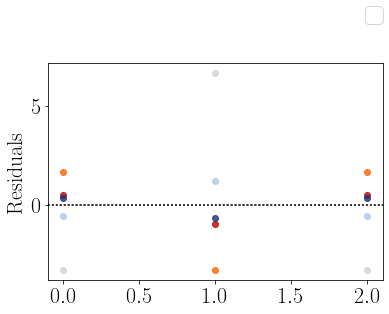

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores           36.566667                   4       9.141667  0.727454          0.593148
Dentro dos fatores          125.666667                  10      12.566667                            
             Total          162.233333                  14                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the mental demand on each method for blinded users.}
\label{tab:anova_mental_demand}
\begin{tabular}{lrrlll}
\toprule
             Fonte &  Soma dos quadrados &  Graus de liberdade & Média quadrada &     F & p-Value (F\_0 > F) \\
\midrule
     Entre fatores &              36.567 &                   4 &          9.142 & 0.727 &             0.593 \\
Dentro dos fatores &             125.667 &                  10 &         12.567 &       &                   \\
             Total &     

In [69]:
if gerar == True:
    anova = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_mental_demand'
caption = 'Anova p-value for the mental demand on each method for blinded users.'
tabela_latex_sem_index(df_summary,label,caption,'Nasa-TLX')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_mental_demand'
caption = 'Cross validation p-value for the mental demand on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Nasa-TLX')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Carga Mental

No handles with labels found to put in legend.


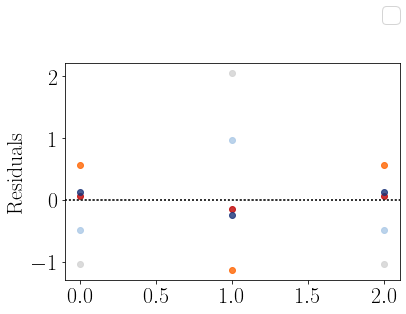

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores            6.175926                   4       1.543981  0.817202          0.542611
Dentro dos fatores           18.893519                  10       1.889352                            
             Total           25.069444                  14                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the Nasa score on each method for blinded users.}
\label{tab:anova_nasa}
\begin{tabular}{rrrrr}
\toprule
 Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
5.417 &  4.833 &        4.833 &         8.000 &    6.083 \\
4.500 &  4.000 &        7.750 &         4.833 &    6.250 \\
4.000 &  3.917 &        4.500 &         5.083 &    3.500 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 1.02 então a hipótese alternativa pode ser v

In [70]:
if gerar == True:
    anova = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_nasa'
caption = 'Anova p-value for the Nasa score on each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Nasa-TLX')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_nasa'
caption = 'Cross validation p-value for the Nasa score on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Nasa-TLX')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Sagat

No handles with labels found to put in legend.


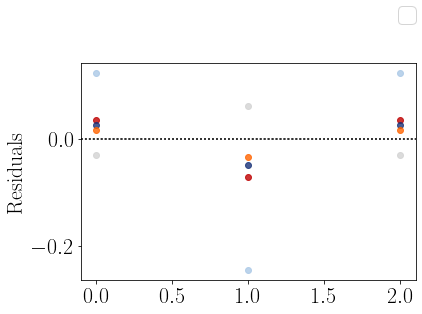

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores            0.021053                   4       0.005263  0.161577          0.953077
Dentro dos fatores            0.325737                  10       0.032574                            
             Total            0.346790                  14                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the Sagat score on each method for blinded users.}
\label{tab:anova_sagat}
\begin{tabular}{rrrrr}
\toprule
 Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
0.600 &  0.475 &        0.400 &         0.550 &    0.738 \\
0.625 &  0.600 &        0.692 &         0.567 &    0.450 \\
0.863 &  0.875 &        0.799 &         0.683 &    0.900 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 0.13 então a hipótese alternativa pode ser

In [71]:
if gerar == True:
    anova = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = saSagat_media_cen_par[saSagat_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_sagat'
caption = 'Anova p-value for the Sagat score on each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Sagat')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_sagat'
caption = 'Cross validation p-value for the Sagat score on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Sagat')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Questionarios

No handles with labels found to put in legend.


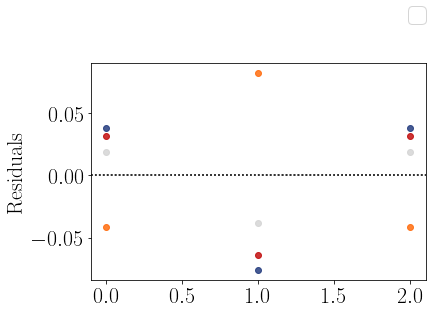

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores            0.161507                   3       0.053836  5.537316          0.023616
Dentro dos fatores            0.077779                   8       0.009722                            
             Total            0.239286                  11                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the questionnaire score on each method for blinded users.}
\label{tab:anova_sagat}
\begin{tabular}{rrrr}
\toprule
 Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
 0.857 &        0.914 &         0.486 &    0.720 \\
 0.631 &        0.714 &         0.457 &    0.849 \\
 0.595 &        0.743 &         0.543 &    0.730 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 0.07 então a hipótese alternativa pode ser valida para essa determi

In [72]:
if gerar == True:
    anova = pgQuestionario_media_2[pgQuestionario_media_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = pgQuestionario_media[pgQuestionario_media['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_sagat'
caption = 'Anova p-value for the questionnaire score on each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Questionario')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_sagat'
caption = 'Cross validation p-value for the questionnaire score on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Questionario')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

## Gráficos

### Gráfico de barra da variação da demanda mental

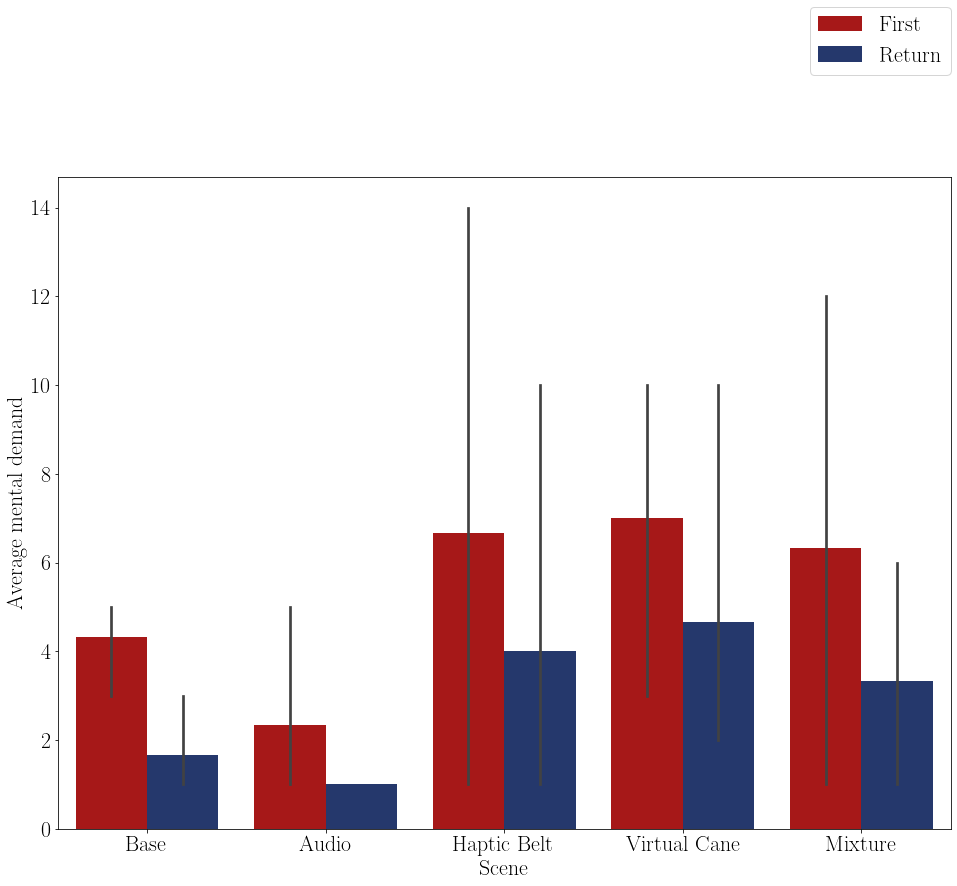

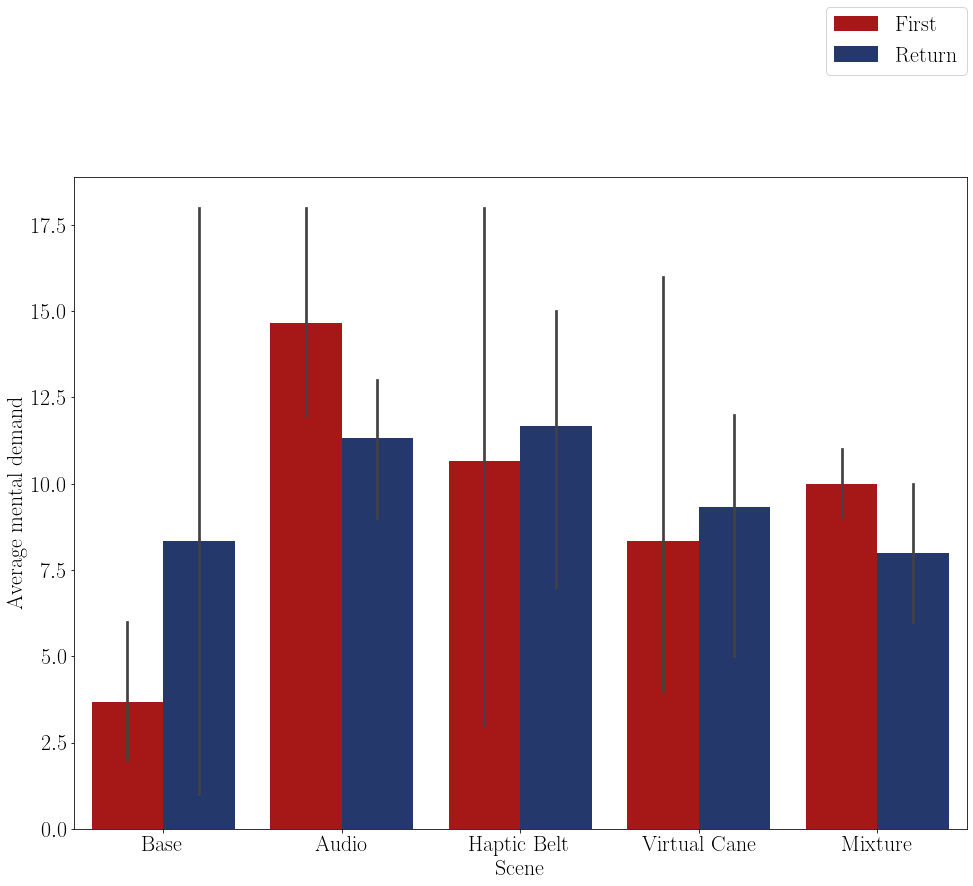

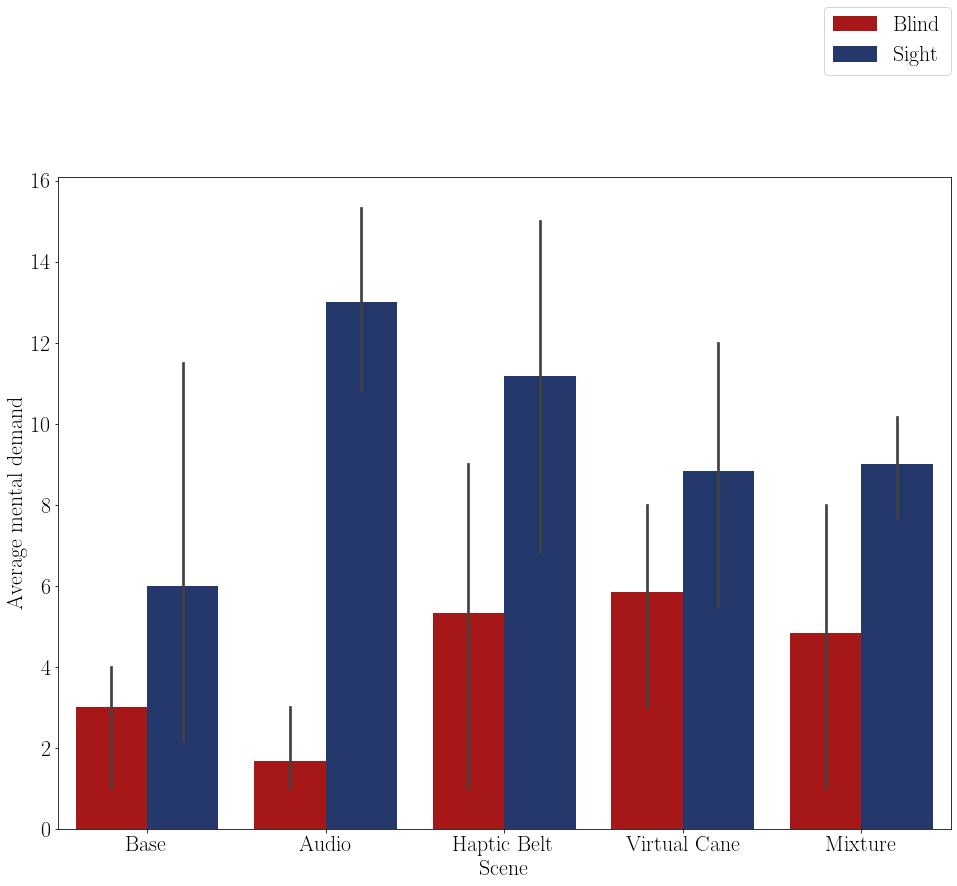

No handles with labels found to put in legend.


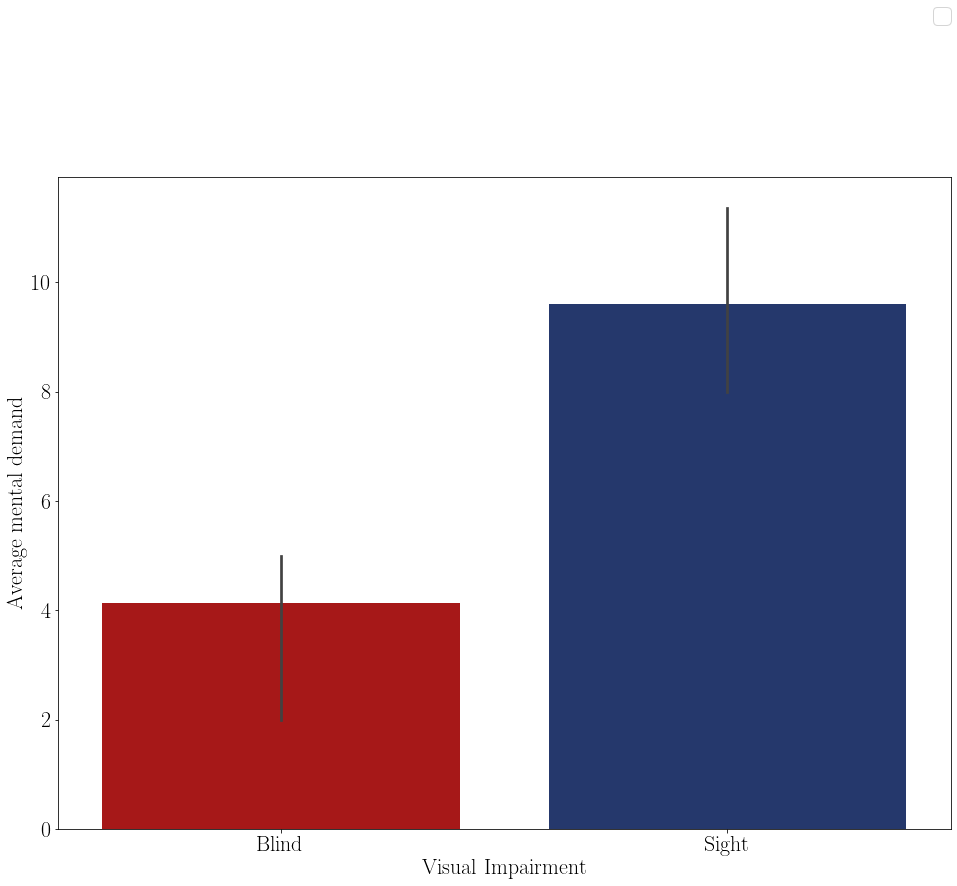

In [89]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfMdVariation_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfMdVariation).reset_index(level = [1,2])
score = 'mental demand'
teste = 'Nasa-TLX'
label = 'md'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da carga mental

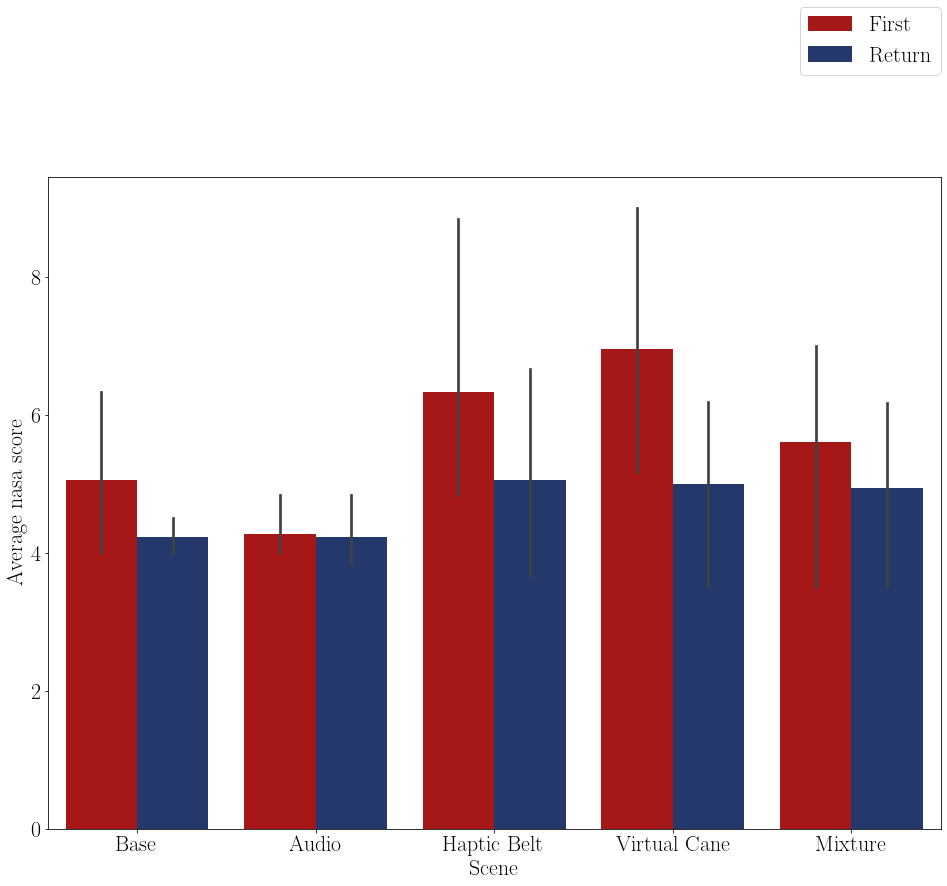

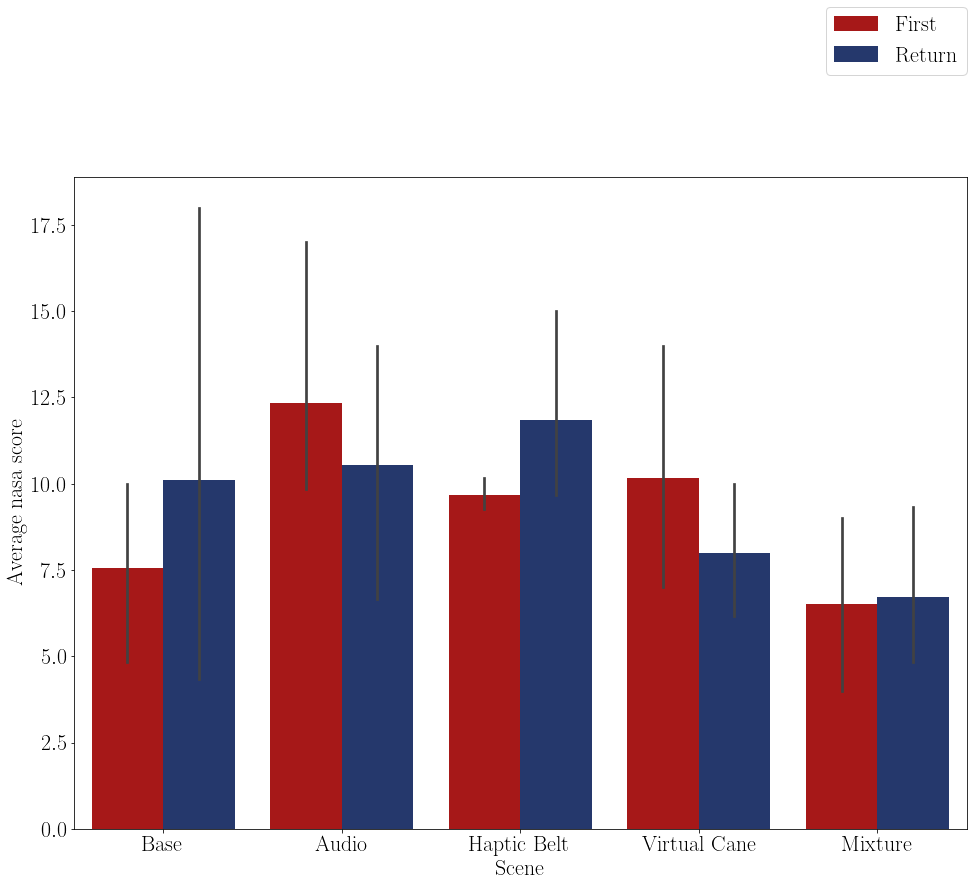

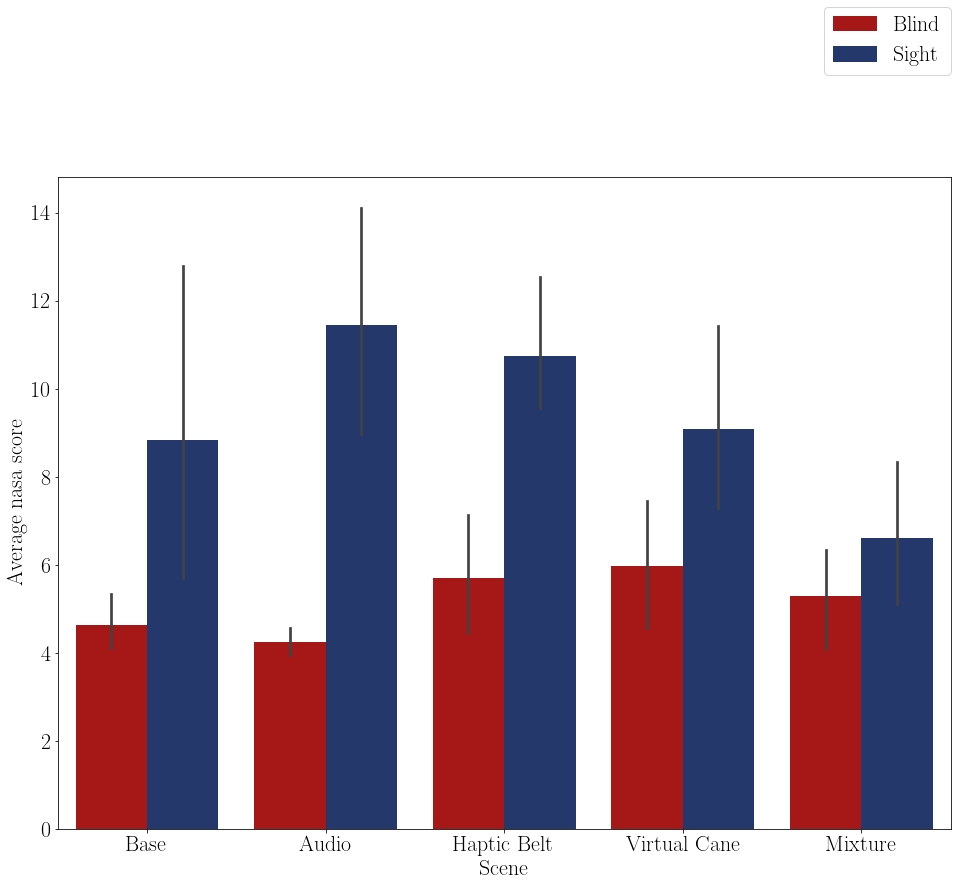

No handles with labels found to put in legend.


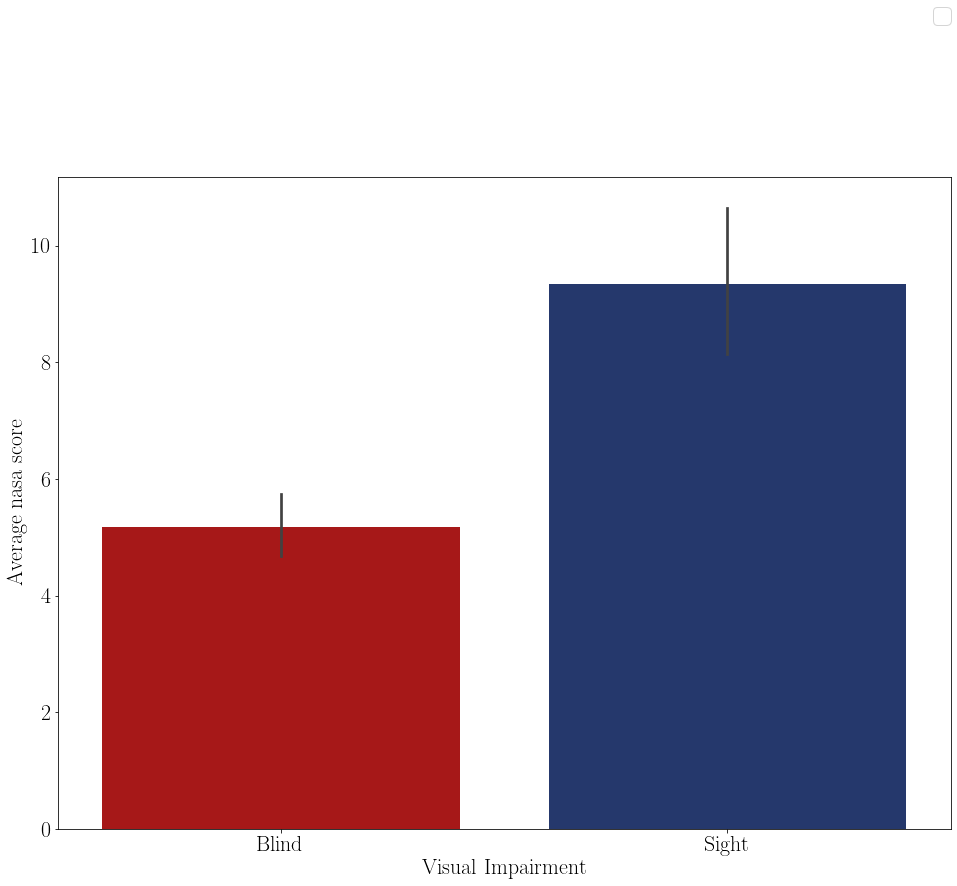

In [90]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfCmVariation_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfCmVariation).reset_index(level = [1,2])
score = 'nasa score'
teste = 'Nasa-TLX'
label = 'nasa'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da pontuação do Sagat

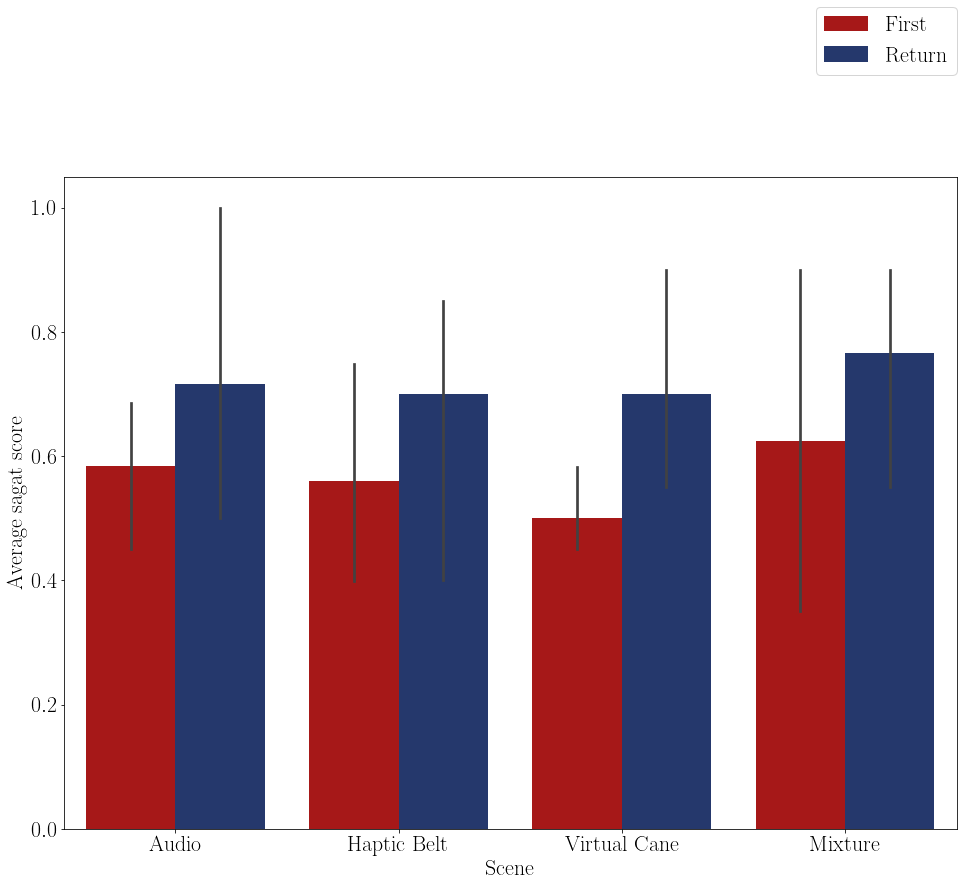

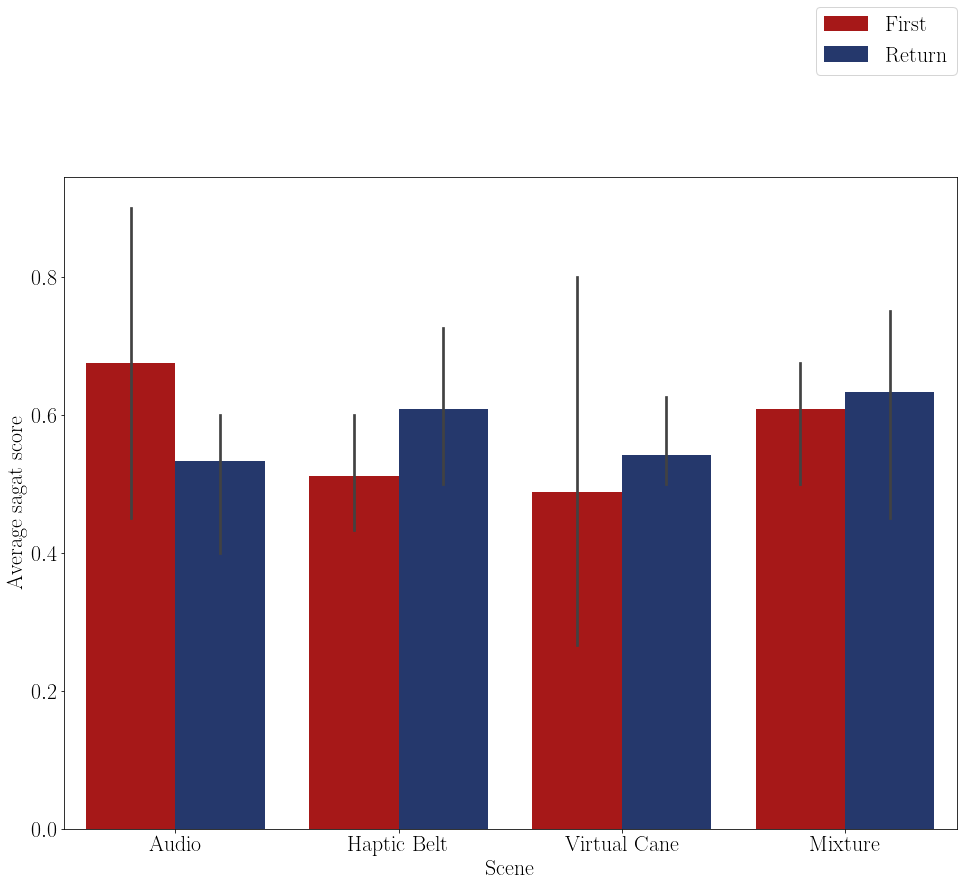

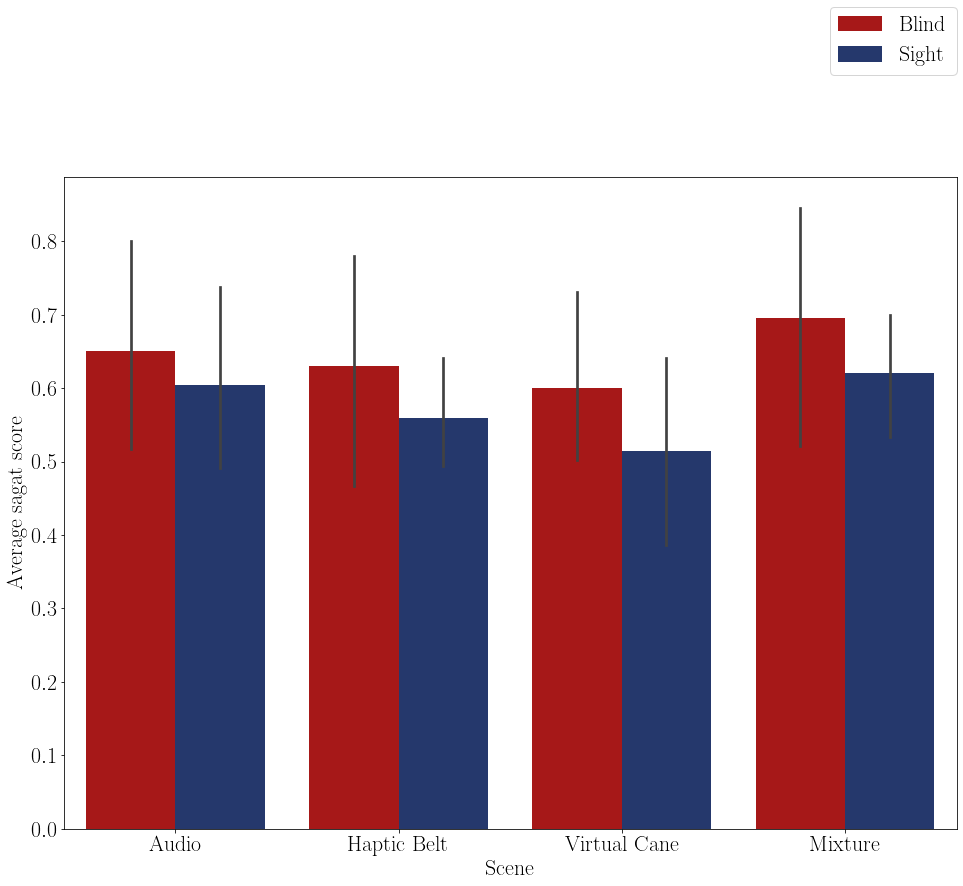

No handles with labels found to put in legend.


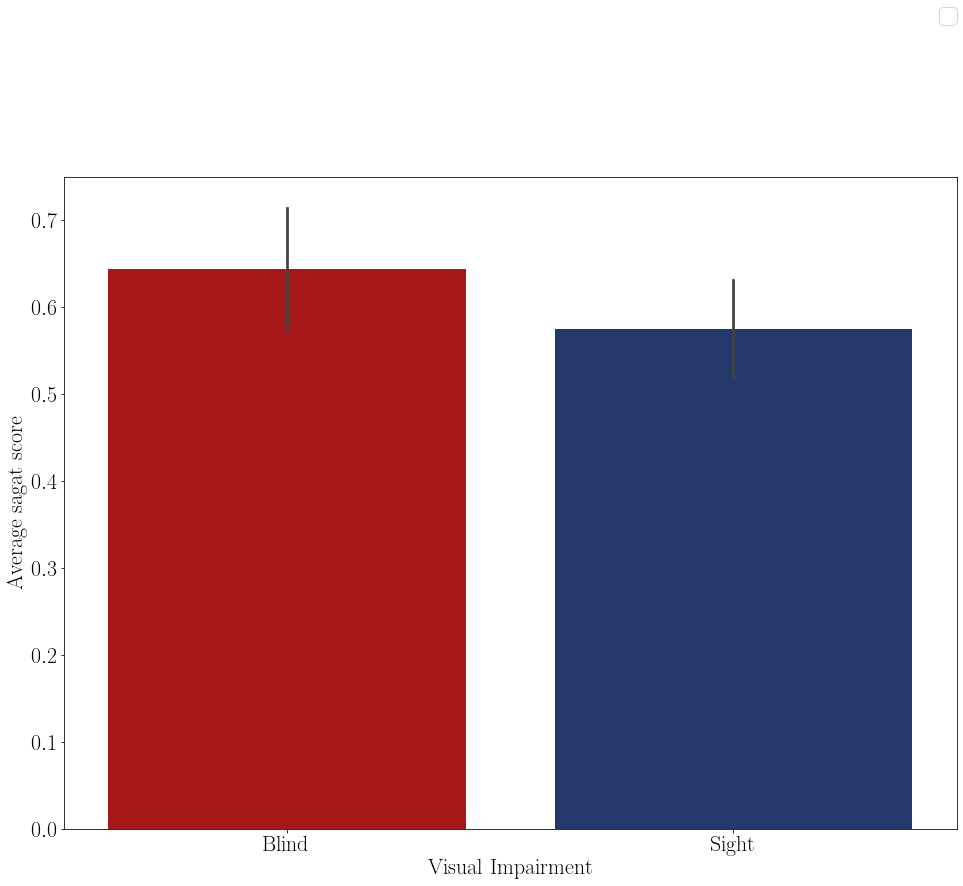

In [91]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfSaVariation_2.drop('Base',axis =1).reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfSaVariation.drop('Base',axis =1)).reset_index(level = [1,2])
score = 'sagat score'
teste = 'Sagat'
label = 'sagat'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da pontuação dos questionários

In [ ]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfSaVariation_2.drop('Base',axis =1).reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfSaVariation.drop('Base',axis =1)).reset_index(level = [1,2])
score = 'sagat score'
teste = 'Sagat'
label = 'sagat'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média da demanda mental

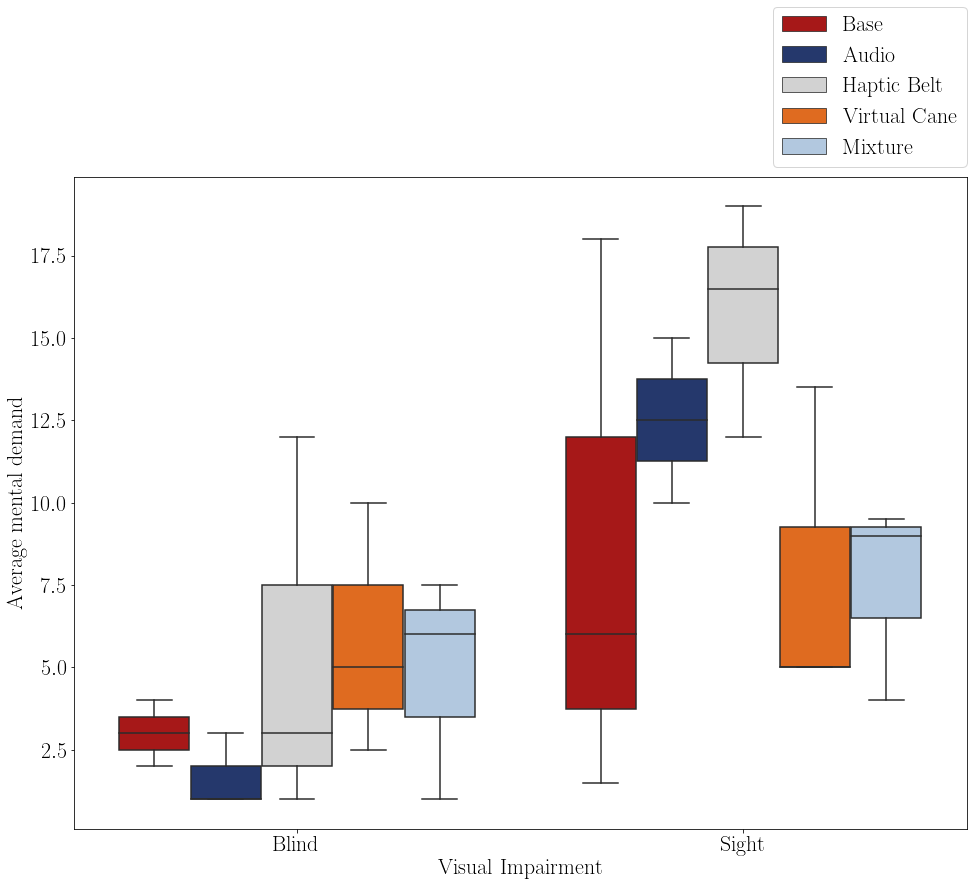

No handles with labels found to put in legend.


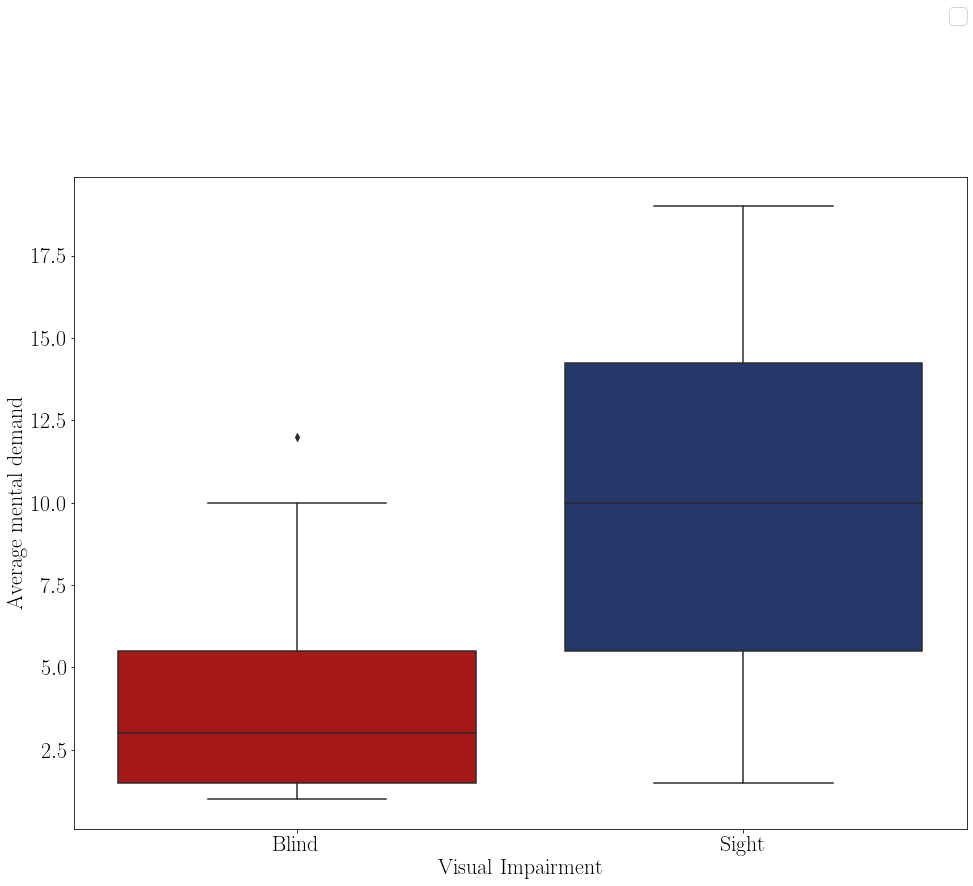

In [77]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(mdNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(mdNasa_media_cen_par)
score = 'mental demand'
teste = 'Nasa-TLX'
label = 'md'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média da Carga Mental

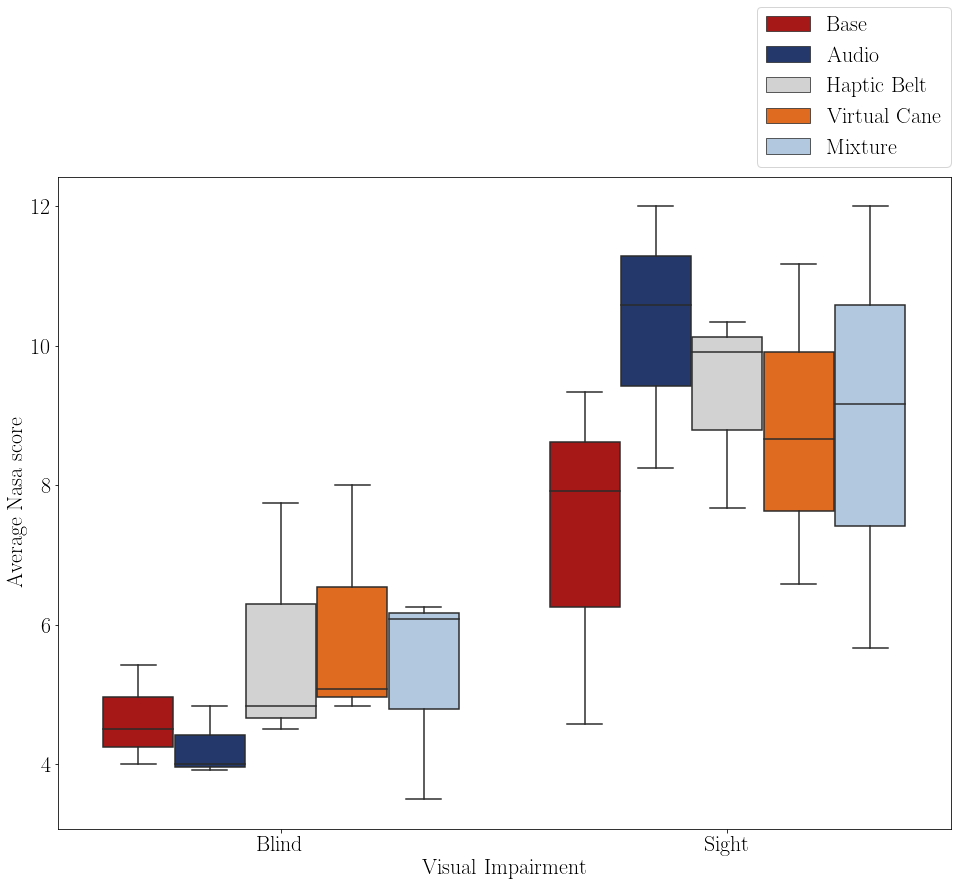

No handles with labels found to put in legend.


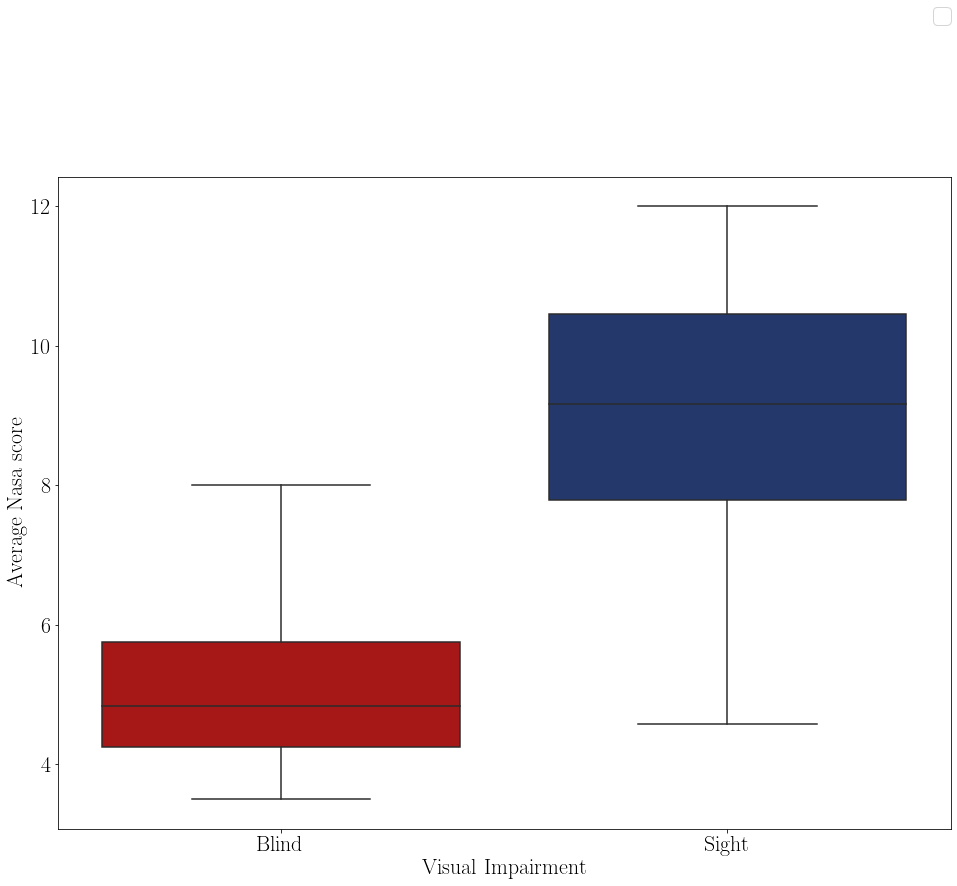

In [78]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(cmNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(cmNasa_media_cen_par_2)

score = 'Nasa score'
teste = 'Nasa-TLX'
label = 'nasa'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média do SAGAT

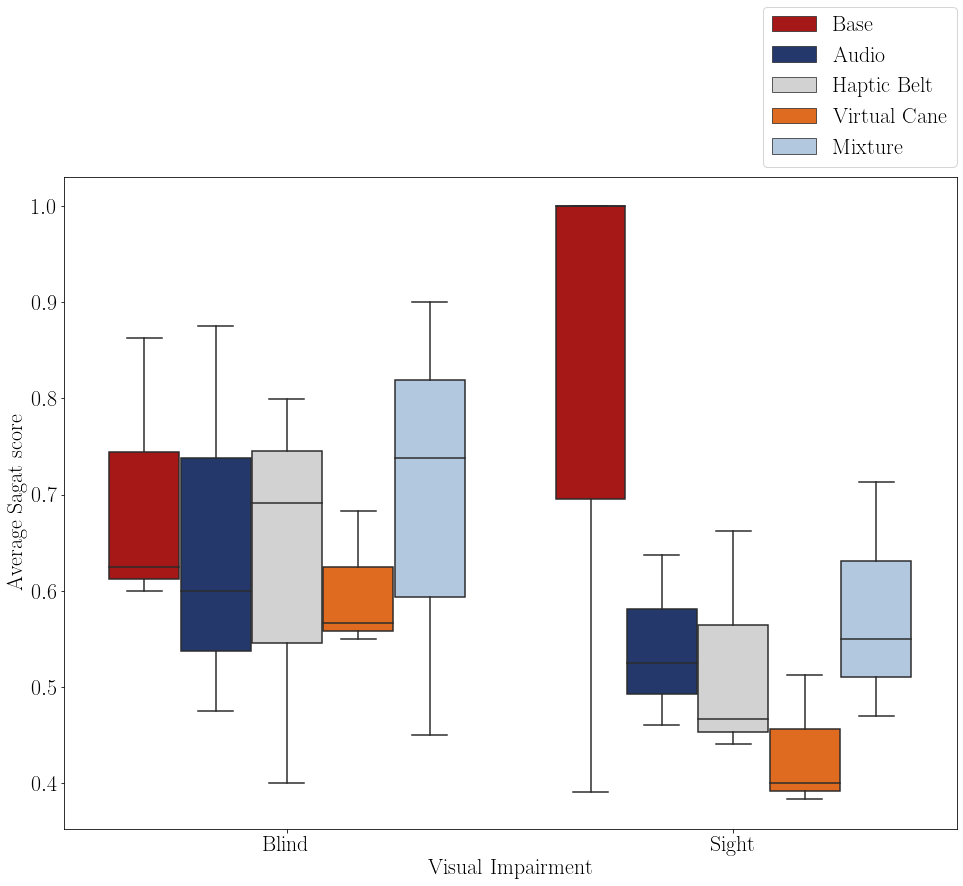

No handles with labels found to put in legend.


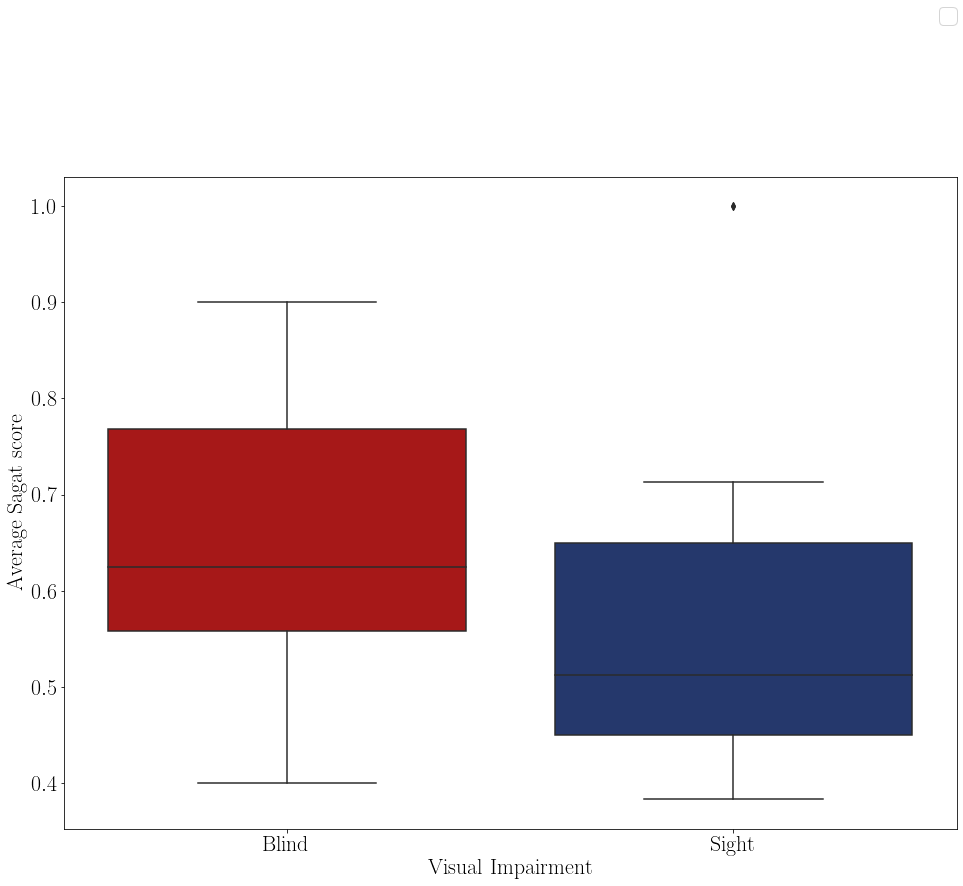

In [79]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(saSagat_media_cen_par_2)
else:
    plot = copy.deepcopy(saSagat_media_cen_par_2)

score = 'Sagat score'
teste = 'SAGAT'
label = 'sagat'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média dos Questionario

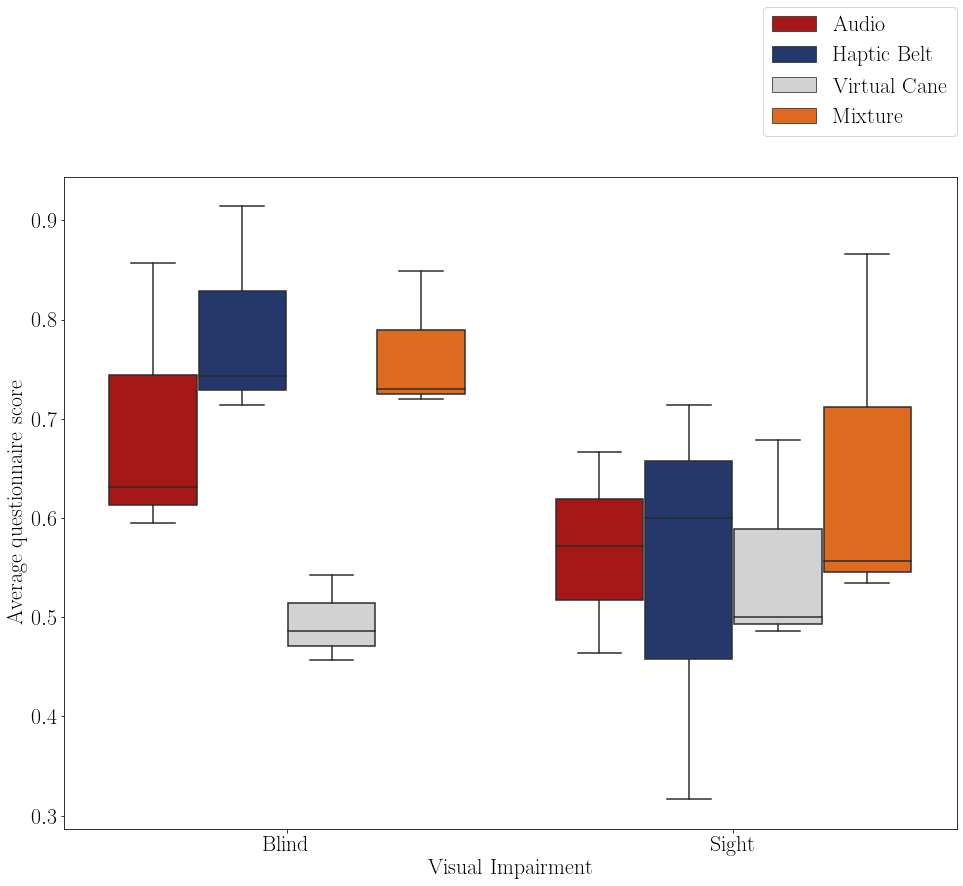

No handles with labels found to put in legend.


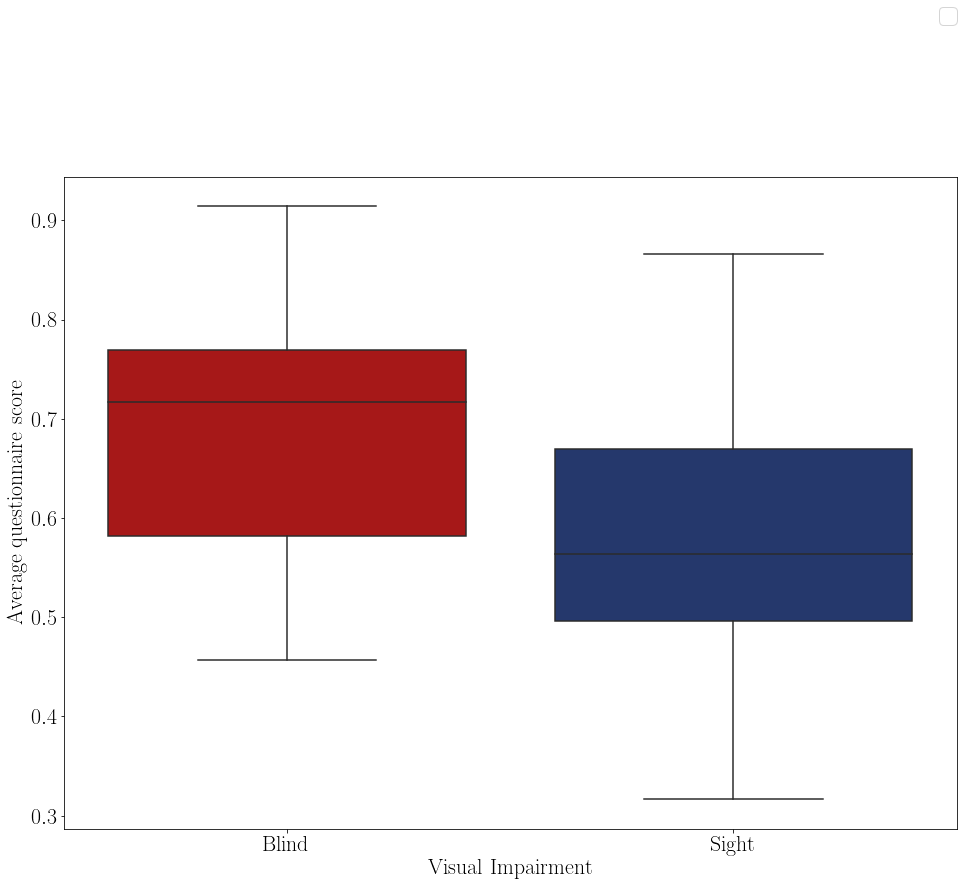

In [80]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(pgQuestionario_media_2)
else:
    plot = copy.deepcopy(pgQuestionario_media_2)

score = 'questionnaire score'
teste = 'Questionario'
label = 'questionnaire'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()